# QuantNote - Tutorial Didático

## Sistema Quantitativo para Probabilidades de Retorno Condicionadas por Regime

Este notebook demonstra passo a passo o funcionamento do sistema QuantNote.

### Objetivo
Calcular a probabilidade de um ativo atingir um retorno alvo em H períodos, condicionada ao regime de mercado atual.

### Conceitos Principais
1. **Log-Retornos**: Usamos log(P_t/P_{t-1}) pois são aditivos e simétricos
2. **Slope (Inclinação)**: Tendência calculada via regressão linear do log-preço
3. **Volatilidade**: Desvio padrão dos retornos em janela móvel
4. **Regimes**: Estados do mercado (bull/bear/flat combinados com alta/baixa volatilidade)
5. **K-Means**: Clustering para detectar regimes automaticamente
6. **Walk-Forward**: Validação para evitar overfitting

## Etapa 1: Setup e Imports

Primeiro, configuramos o ambiente e importamos os módulos necessários.

In [1]:
# Setup do path para imports
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Imports padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verificar se os imports funcionam
print("Python path configurado!")
print(f"Diretório de trabalho: {os.getcwd()}")

# Configuração de visualização
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

Python path configurado!
Diretório de trabalho: /home/flavio/projetos/quantnote/notebooks


## Etapa 2: Configuração do Sistema

O sistema usa Pydantic para validar configurações. Isso garante que parâmetros inválidos sejam rejeitados.

In [2]:
from config.settings import AnalysisConfig, InfrastructureConfig, Config
from config.search_space import GAConfig, GASearchSpace

# =============================================================================
# CONFIGURAÇÃO CENTRALIZADA
# =============================================================================
# Altere os parâmetros abaixo conforme necessário.
# Todos os notebooks usarão estas configurações.

# --- Ticker a analisar ---
TICKER = "BOVA11.SA"

# --- Parâmetros de Predição (usados pelo GA) ---
TARGET_RETURN = 0.03   # Target: 3% de variação
HORIZON = 7            # Horizonte: 7 dias

# --- Indicadores Ativos ---
# Controla quais indicadores são usados em TODO o notebook:
# - Pipeline de calculadores
# - Espaço de busca do GA (parâmetros do indicador)
# - Features do K-Means
# - Features do Explainer (Decision Tree / Random Forest)
#
# True  = Indicador sempre ativo (GA otimiza os parâmetros)
# False = Indicador desabilitado (não entra no pipeline/GA/K-Means/Explainer)
USE_VOLATILITY = False        # Volatilidade (desvio padrão dos retornos)
USE_ROLLING_RETURN = False    # Retorno acumulado em janela
USE_MA_DISTANCE = True       # Distância entre MAs (rápida - lenta)
USE_TREND_INDICATOR = False   # Trend Indicator (higher lows / lower highs)

# --- Parâmetros do GA Principal ---
GA_POPULATION_SIZE = 100
GA_GENERATIONS = 1000
GA_N_FOLDS = 3
GA_EARLY_STOPPING = True

# --- Parâmetros do GA para Multi-Target/Strike Grid (reduzido para demo) ---
MULTI_GA_POPULATION_SIZE = 50
MULTI_GA_GENERATIONS = 100

# --- Parâmetros de Análise Exploratória (Etapas 1-11) ---
ANALYSIS_WINDOW_SLOPE = 20
ANALYSIS_WINDOW_VOLATILITY = 20
ANALYSIS_WINDOW_ROLLING_RETURN = 20
ANALYSIS_WINDOW_TREND_INDICATOR = 10
ANALYSIS_TREND_SLOPE_MULTIPLIER = 2.0  # Janela do slope = window * multiplier
ANALYSIS_N_CLUSTERS = 6
ANALYSIS_TARGET_RETURN = 0.05  # 5% para exploração didática

# --- Parâmetros de Médias Móveis ---
MA_FAST_PERIOD = 9     # Média móvel rápida
MA_SLOW_PERIOD = 21    # Média móvel lenta

# =============================================================================
# Criar objetos de configuração
# =============================================================================

# Config para análise exploratória (etapas iniciais do notebook)
config = Config()
config.analysis.future_return_periods = HORIZON
config.analysis.window_slope = ANALYSIS_WINDOW_SLOPE
config.analysis.window_volatility = ANALYSIS_WINDOW_VOLATILITY
config.analysis.window_rolling_return = ANALYSIS_WINDOW_ROLLING_RETURN
config.analysis.window_trend_indicator = ANALYSIS_WINDOW_TREND_INDICATOR
config.analysis.trend_slope_multiplier = ANALYSIS_TREND_SLOPE_MULTIPLIER
config.analysis.n_clusters = ANALYSIS_N_CLUSTERS
config.analysis.target_return = ANALYSIS_TARGET_RETURN
config.analysis.ma_fast_period = MA_FAST_PERIOD
config.analysis.ma_slow_period = MA_SLOW_PERIOD

# Configurar indicadores ativos
config.analysis.use_volatility = USE_VOLATILITY
config.analysis.use_rolling_return = USE_ROLLING_RETURN
config.analysis.use_ma_distance = USE_MA_DISTANCE
config.analysis.use_trend_indicator = USE_TREND_INDICATOR

# Config do GA para otimização principal
# Os flags force_use_* controlam se o indicador é forçado a True, False, ou None (GA decide)
# Quando USE_* = True, forçamos True para sempre usar
# Quando USE_* = False, forçamos False para nunca usar
ga_config = GAConfig(
    target_return=TARGET_RETURN,
    horizon=HORIZON,
    population_size=GA_POPULATION_SIZE,
    generations=GA_GENERATIONS,
    n_folds=GA_N_FOLDS,
    stability_penalty=0.1,
    elite_size=2,
    early_stopping=GA_EARLY_STOPPING,
    # Forçar indicadores conforme configuração global
    force_use_volatility=USE_VOLATILITY,
    force_use_rolling_return=USE_ROLLING_RETURN,
    force_use_ma_distance=USE_MA_DISTANCE,
    force_use_trend_indicator=USE_TREND_INDICATOR,
)

# Config do GA para multi-target e strike grid (reduzido)
multi_ga_config = GAConfig(
    target_return=TARGET_RETURN,  # Será sobrescrito pelo optimizer
    horizon=HORIZON,
    population_size=MULTI_GA_POPULATION_SIZE,
    generations=MULTI_GA_GENERATIONS,
    n_folds=GA_N_FOLDS,
    early_stopping=GA_EARLY_STOPPING,
    # Forçar indicadores conforme configuração global
    force_use_volatility=USE_VOLATILITY,
    force_use_rolling_return=USE_ROLLING_RETURN,
    force_use_ma_distance=USE_MA_DISTANCE,
    force_use_trend_indicator=USE_TREND_INDICATOR,
)

# =============================================================================
# Exibir configurações
# =============================================================================
print("=" * 60)
print("CONFIGURAÇÃO CENTRALIZADA")
print("=" * 60)

print(f"\n📊 TICKER: {TICKER}")

print(f"\n🎯 Parâmetros de Predição:")
print(f"   Target Return: {TARGET_RETURN:.1%}")
print(f"   Horizonte: {HORIZON} dias")

print(f"\n📈 Indicadores Ativos:")
print(f"   {'✅' if USE_VOLATILITY else '❌'} Volatility")
print(f"   {'✅' if USE_ROLLING_RETURN else '❌'} Rolling Return")
print(f"   {'✅' if USE_MA_DISTANCE else '❌'} MA Distance")
print(f"   {'✅' if USE_TREND_INDICATOR else '❌'} Trend Indicator")
active_count = sum([USE_VOLATILITY, USE_ROLLING_RETURN, USE_MA_DISTANCE, USE_TREND_INDICATOR])
print(f"   Total: {active_count + 1} features (slope é sempre incluído)")

print(f"\n🧬 GA Principal:")
print(f"   População: {GA_POPULATION_SIZE}")
print(f"   Gerações: {GA_GENERATIONS}")
print(f"   Folds: {GA_N_FOLDS}")
print(f"   Early Stopping: {GA_EARLY_STOPPING}")

print(f"\n🎯 GA Multi-Target/Strike Grid:")
print(f"   População: {MULTI_GA_POPULATION_SIZE}")
print(f"   Gerações: {MULTI_GA_GENERATIONS}")

print(f"\n📈 Análise Exploratória:")
print(f"   Window Slope: {ANALYSIS_WINDOW_SLOPE}")
if USE_VOLATILITY:
    print(f"   Window Volatility: {ANALYSIS_WINDOW_VOLATILITY}")
if USE_ROLLING_RETURN:
    print(f"   Window Rolling Return: {ANALYSIS_WINDOW_ROLLING_RETURN}")
if USE_TREND_INDICATOR:
    print(f"   Window Trend Indicator: {ANALYSIS_WINDOW_TREND_INDICATOR}")
    print(f"   Trend Slope Multiplier: {ANALYSIS_TREND_SLOPE_MULTIPLIER}")
print(f"   Clusters: {ANALYSIS_N_CLUSTERS}")
print(f"   Target (exploratório): {ANALYSIS_TARGET_RETURN:.1%}")

if USE_MA_DISTANCE:
    print(f"\n📉 Médias Móveis:")
    print(f"   MA Rápida: {MA_FAST_PERIOD} períodos")
    print(f"   MA Lenta: {MA_SLOW_PERIOD} períodos")

print("\n" + "=" * 60)

CONFIGURAÇÃO CENTRALIZADA

📊 TICKER: BOVA11.SA

🎯 Parâmetros de Predição:
   Target Return: 3.0%
   Horizonte: 7 dias

📈 Indicadores Ativos:
   ❌ Volatility
   ❌ Rolling Return
   ✅ MA Distance
   ❌ Trend Indicator
   Total: 2 features (slope é sempre incluído)

🧬 GA Principal:
   População: 100
   Gerações: 1000
   Folds: 3
   Early Stopping: True

🎯 GA Multi-Target/Strike Grid:
   População: 50
   Gerações: 100

📈 Análise Exploratória:
   Window Slope: 20
   Clusters: 6
   Target (exploratório): 5.0%

📉 Médias Móveis:
   MA Rápida: 9 períodos
   MA Lenta: 21 períodos



## Etapa 3: Obtenção de Dados

Usamos `YahooDataSource` para baixar dados OHLCV. O sistema tem rate limiting para evitar bloqueio.

In [3]:
from src.infrastructure.yahoo_data_source import YahooDataSource
from src.infrastructure.parquet_repository import ParquetRepository
from src.infrastructure.file_logger import FileLogger, NullLogger

# Criar logger (usar NullLogger para menos output)
logger = NullLogger()  # ou FileLogger("quantnote") para logs detalhados

# Data source e repository
data_source = YahooDataSource(calls_per_minute=5, logger=logger)
repository = ParquetRepository(data_dir="../data", logger=logger)

# Usar ticker da configuração centralizada
ticker = TICKER

print(f"Buscando dados para {ticker}...")

# Verificar se dados no cache estão atualizados
is_current, last_date = repository.is_data_current(ticker, max_age_days=1)

if is_current:
    print(f"✅ Cache atualizado (última data: {last_date.date()})")
    df = repository.load(ticker)
else:
    if last_date:
        print(f"⚠️  Cache desatualizado (última data: {last_date.date()})")
    else:
        print("📥 Dados não encontrados no cache.")
    
    print("Baixando dados atualizados do Yahoo Finance...")
    df = data_source.fetch_ohlcv(ticker)
    
    # Limpar arquivos antigos e salvar novos dados
    deleted = repository.delete_old_files(ticker, keep_latest=0)
    if deleted:
        print(f"🗑️  {deleted} arquivo(s) antigo(s) removido(s)")
    
    repository.save(df, ticker)
    print("✅ Dados atualizados salvos no cache.")

print(f"\n=== Dados Obtidos ===")
print(f"Shape: {df.shape}")
print(f"Período: {df['date'].min().date()} a {df['date'].max().date()}")
print(f"\nPrimeiras linhas:")
df.head()

Buscando dados para BOVA11.SA...
✅ Cache atualizado (última data: 2025-12-01)

=== Dados Obtidos ===
Shape: (4101, 6)
Período: 2009-04-17 a 2025-12-01

Primeiras linhas:


,date,open,high,low,close,volume
0,2009-04-17,45.700001,45.980000,45.599998,45.849998,274700
1,2009-04-20,44.790001,44.900002,44.070000,44.419998,265800
2,2009-04-22,44.610001,45.240002,44.509998,44.990002,234800
3,2009-04-23,45.189999,45.900002,44.860001,45.900002,305900
4,2009-04-24,46.169998,46.849998,46.099998,46.689999,325600


## Etapa 4: Validação de Dados

Antes de processar, validamos os dados para garantir qualidade.

O sistema usa o padrão **Composite** para combinar múltiplos validadores.

In [4]:
from src.infrastructure.validators import create_default_validator

# Criar validador composto
validator = create_default_validator(
    min_length=config.analysis.min_data_points,
    max_window=max(
        config.analysis.window_slope, 
        config.analysis.window_volatility,
        config.analysis.window_trend_indicator
    )
)

# Executar validação
validation = validator.validate(df)

print("=== Resultado da Validação ===")
print(f"Válido: {'SIM' if validation.is_valid else 'NÃO'}")

if validation.errors:
    print(f"\nERROS:")
    for error in validation.errors:
        print(f"  - {error}")

if validation.warnings:
    print(f"\nAVISOS:")
    for warning in validation.warnings:
        print(f"  - {warning}")

if validation.is_valid and not validation.warnings:
    print("Todos os testes passaram sem avisos!")


=== Resultado da Validação ===
Válido: SIM

AVISOS:
  - Gaps > 5 days found: ['2012-02-23 (6.0 days)', '2018-03-06 (6.0 days)', '2019-03-06 (7.0 days)', '2019-03-21 (8.0 days)']


## Etapa 5: Calculadores Individuais

Vamos explorar cada calculador individualmente para entender o que faz.

Cada calculador implementa `IColumnCalculator` e segue o princípio de **Single Responsibility**.

In [5]:
from src.calculators.log_price_calculator import LogPriceCalculator

# 5.1 - Log Price Calculator
log_price_calc = LogPriceCalculator()

print("=== LogPriceCalculator ===")
print(f"Nome: {log_price_calc.name}")
print(f"Colunas requeridas: {log_price_calc.required_columns}")
print(f"Colunas produzidas: {log_price_calc.output_columns}")

# Aplicar
df_step1 = log_price_calc.calculate(df)

# Visualizar resultado
print(f"\nFormula: log_close = ln(close)")
print(f"\nExemplo:")
print(df_step1[['date', 'close', 'log_close']].head())

=== LogPriceCalculator ===
Nome: log_price
Colunas requeridas: {'close'}
Colunas produzidas: {'log_close'}

Formula: log_close = ln(close)

Exemplo:
        date      close  log_close
0 2009-04-17  45.849998   3.825375
1 2009-04-20  44.419998   3.793690
2 2009-04-22  44.990002   3.806440
3 2009-04-23  45.900002   3.826465
4 2009-04-24  46.689999   3.843530


In [6]:
from src.calculators.log_return_calculator import LogReturnCalculator

# 5.2 - Log Return Calculator
log_return_calc = LogReturnCalculator(window=config.analysis.window_rolling_return)

print("=== LogReturnCalculator ===")
print(f"Nome: {log_return_calc.name}")
print(f"Colunas requeridas: {log_return_calc.required_columns}")
print(f"Colunas produzidas: {log_return_calc.output_columns}")

# Aplicar
df_step2 = log_return_calc.calculate(df_step1)

print(f"\nFormulas:")
print(f"  log_return = ln(close_t / close_{{t-1}})")
print(f"  log_return_rolling_20 = sum(log_return over 20 days)")
print(f"\nExemplo:")
print(df_step2[['date', 'close', 'log_return', f'log_return_rolling_{config.analysis.window_rolling_return}']].head(25))

=== LogReturnCalculator ===
Nome: log_return_w20
Colunas requeridas: {'close'}
Colunas produzidas: {'log_return', 'log_return_rolling_20'}

Formulas:
  log_return = ln(close_t / close_{t-1})
  log_return_rolling_20 = sum(log_return over 20 days)

Exemplo:
         date      close  log_return  log_return_rolling_20
0  2009-04-17  45.849998         NaN                    NaN
1  2009-04-20  44.419998   -0.031685                    NaN
2  2009-04-22  44.990002    0.012751                    NaN
3  2009-04-23  45.900002    0.020025                    NaN
4  2009-04-24  46.689999    0.017065                    NaN
5  2009-04-27  45.900002   -0.017065                    NaN
6  2009-04-28  45.849998   -0.001090                    NaN
7  2009-04-29  46.799999    0.020508                    NaN
8  2009-04-30  48.099998    0.027399                    NaN
9  2009-05-04  50.000000    0.038741                    NaN
10 2009-05-05  50.650002    0.012916                    NaN
11 2009-05-06  51.360001

In [7]:
from src.calculators.volatility_calculator import VolatilityCalculator

# 5.3 - Volatility Calculator
vol_calc = VolatilityCalculator(window=config.analysis.window_volatility)

print("=== VolatilityCalculator ===")
print(f"Nome: {vol_calc.name}")
print(f"Colunas requeridas: {vol_calc.required_columns}")
print(f"Colunas produzidas: {vol_calc.output_columns}")

# Aplicar
df_step3 = vol_calc.calculate(df_step2)

print(f"\nFormula: volatility = std(log_return over {config.analysis.window_volatility} days)")
print(f"\nExemplo:")
print(df_step3[['date', 'log_return', f'volatility_{config.analysis.window_volatility}']].tail(10))

=== VolatilityCalculator ===
Nome: volatility_w20
Colunas requeridas: {'log_return'}
Colunas produzidas: {'volatility_20'}

Formula: volatility = std(log_return over 20 days)

Exemplo:
           date  log_return  volatility_20
4091 2025-11-17   -0.003570       0.005895
4092 2025-11-18   -0.001692       0.005942
4093 2025-11-19   -0.010015       0.006732
4094 2025-11-21   -0.000329       0.006762
4095 2025-11-24    0.002629       0.006760
4096 2025-11-25    0.004061       0.006704
4097 2025-11-26    0.017946       0.007483
4098 2025-11-27   -0.002700       0.007584
4099 2025-11-28    0.003406       0.007583
4100 2025-12-01   -0.002248       0.007675


In [8]:
from src.calculators.slope_calculator import SlopeCalculator

# 5.4 - Slope Calculator
slope_calc = SlopeCalculator(window=config.analysis.window_slope)

print("=== SlopeCalculator ===")
print(f"Nome: {slope_calc.name}")
print(f"Colunas requeridas: {slope_calc.required_columns}")
print(f"Colunas produzidas: {slope_calc.output_columns}")

# Aplicar
df_step4 = slope_calc.calculate(df_step3)

print(f"\nFormula: slope = coef angular da regressão linear de log_close sobre {config.analysis.window_slope} dias")
print(f"\nInterpretação:")
print(f"  slope > 0: tendência de alta")
print(f"  slope < 0: tendência de baixa")
print(f"  slope ≈ 0: mercado lateral")
print(f"\nExemplo:")
print(df_step4[['date', 'log_close', f'slope_{config.analysis.window_slope}']].tail(10))

=== SlopeCalculator ===
Nome: slope_w20
Colunas requeridas: {'log_close'}
Colunas produzidas: {'slope_20'}

Formula: slope = coef angular da regressão linear de log_close sobre 20 dias

Interpretação:
  slope > 0: tendência de alta
  slope < 0: tendência de baixa
  slope ≈ 0: mercado lateral

Exemplo:
           date  log_close  slope_20
4091 2025-11-17   5.035588  0.005248
4092 2025-11-18   5.033896  0.004996
4093 2025-11-19   5.023881  0.004554
4094 2025-11-21   5.023551  0.004093
4095 2025-11-24   5.026181  0.003609
4096 2025-11-25   5.030242  0.003199
4097 2025-11-26   5.048188  0.002989
4098 2025-11-27   5.045488  0.002733
4099 2025-11-28   5.048894  0.002468
4100 2025-12-01   5.046646  0.002147


In [9]:
from src.calculators.ma_distance_calculator import MADistanceCalculator

# 5.5 - MA Distance Calculator
ma_dist_calc = MADistanceCalculator(
    fast_period=config.analysis.ma_fast_period,
    slow_period=config.analysis.ma_slow_period
)

print("=== MADistanceCalculator ===")
print(f"Nome: {ma_dist_calc.name}")
print(f"Colunas requeridas: {ma_dist_calc.required_columns}")
print(f"Colunas produzidas: {ma_dist_calc.output_columns}")

# Aplicar
df_step4b = ma_dist_calc.calculate(df_step4)

ma_col = f'ma_dist_{config.analysis.ma_fast_period}_{config.analysis.ma_slow_period}'

print(f"\nFormula:")
print(f"  MA_fast = SMA(close, {config.analysis.ma_fast_period})")
print(f"  MA_slow = SMA(close, {config.analysis.ma_slow_period})")
print(f"  distance = MA_fast - MA_slow")
print(f"  {ma_col} = normalize(distance, min=-1, max=1)")

print(f"\nInterpretação:")
print(f"  > 0: tendência de alta (MA rápida > MA lenta)")
print(f"  < 0: tendência de baixa (MA rápida < MA lenta)")
print(f"  ≈ 0: médias cruzando/convergindo")

print(f"\nExemplo:")
print(df_step4b[['date', 'close', ma_col]].tail(10))

=== MADistanceCalculator ===
Nome: ma_distance_9_21
Colunas requeridas: {'close'}
Colunas produzidas: {'ma_dist_9_21'}

Formula:
  MA_fast = SMA(close, 9)
  MA_slow = SMA(close, 21)
  distance = MA_fast - MA_slow
  ma_dist_9_21 = normalize(distance, min=-1, max=1)

Interpretação:
  > 0: tendência de alta (MA rápida > MA lenta)
  < 0: tendência de baixa (MA rápida < MA lenta)
  ≈ 0: médias cruzando/convergindo

Exemplo:
           date       close  ma_dist_9_21
4091 2025-11-17  153.789993      0.922093
4092 2025-11-18  153.529999      0.901597
4093 2025-11-19  152.000000      0.874895
4094 2025-11-21  151.949997      0.844060
4095 2025-11-24  152.350006      0.804668
4096 2025-11-25  152.970001      0.745226
4097 2025-11-26  155.740005      0.708881
4098 2025-11-27  155.320007      0.674846
4099 2025-11-28  155.850006      0.645514
4100 2025-12-01  155.500000      0.621261


In [10]:
from src.calculators.trend_indicator_calculator import TrendIndicatorCalculator

# 5.5b - Trend Indicator Calculator
# Indicador de tendência baseado em Higher Lows e Lower Highs, filtrado pela direção do slope
trend_calc = TrendIndicatorCalculator(
    window=config.analysis.window_trend_indicator,
    slope_multiplier=config.analysis.trend_slope_multiplier
)

print("=== TrendIndicatorCalculator ===")
print(f"Nome: {trend_calc.name}")
print(f"Colunas requeridas: {trend_calc.required_columns}")
print(f"Colunas produzidas: {trend_calc.output_columns}")

# Aplicar
df_step4c = trend_calc.calculate(df_step4b)

window = config.analysis.window_trend_indicator
slope_window = int(window * config.analysis.trend_slope_multiplier)

print(f"\n=== Lógica ===")
print(f"1. Calcula slope em janela de {slope_window} dias (window * multiplier)")
print(f"2. Se slope > 0 (uptrend): conta higher_lows na janela de {window} dias → valor POSITIVO")
print(f"3. Se slope <= 0 (downtrend): conta lower_highs na janela de {window} dias → valor NEGATIVO")

print(f"\n=== Colunas de Saída ===")
print(f"- trend_indicator_{window}: Valor COM sinal (+higher_lows ou -lower_highs)")
print(f"- trend_indicator_norm_{window}: Normalizado entre -1 e +1")
print(f"- trend_strength_{window}: Valor absoluto (força sem direção)")
print(f"- trend_strength_norm_{window}: Força normalizada entre 0 e 1")

print(f"\n=== Uso ===")
print(f"- Para visualização/interpretação: use trend_indicator (com sinal)")
print(f"- Para K-Means clustering: use trend_strength (abs) para evitar redundância com slope")
print(f"  (O sinal já está capturado pelo slope, então usamos apenas a magnitude)")

print(f"\n=== Amostra (valores com sinal) ===")
trend_cols = [f'trend_indicator_{window}', f'trend_indicator_norm_{window}']
print(df_step4c[['date', 'high', 'low'] + trend_cols].dropna().tail(10))

print(f"\n=== Amostra (força absoluta - usada no K-Means) ===")
strength_cols = [f'trend_strength_{window}', f'trend_strength_norm_{window}']
print(df_step4c[['date'] + strength_cols].dropna().tail(10))

=== TrendIndicatorCalculator ===
Nome: trend_indicator_w10_m2.0
Colunas requeridas: {'high', 'close', 'low'}
Colunas produzidas: {'trend_indicator_norm_10', 'trend_strength_10', 'trend_indicator_10', 'trend_strength_norm_10'}

=== Lógica ===
1. Calcula slope em janela de 20 dias (window * multiplier)
2. Se slope > 0 (uptrend): conta higher_lows na janela de 10 dias → valor POSITIVO
3. Se slope <= 0 (downtrend): conta lower_highs na janela de 10 dias → valor NEGATIVO

=== Colunas de Saída ===
- trend_indicator_10: Valor COM sinal (+higher_lows ou -lower_highs)
- trend_indicator_norm_10: Normalizado entre -1 e +1
- trend_strength_10: Valor absoluto (força sem direção)
- trend_strength_norm_10: Força normalizada entre 0 e 1

=== Uso ===
- Para visualização/interpretação: use trend_indicator (com sinal)
- Para K-Means clustering: use trend_strength (abs) para evitar redundância com slope
  (O sinal já está capturado pelo slope, então usamos apenas a magnitude)

=== Amostra (valores com sin

In [11]:
from src.calculators.future_return_calculator import FutureReturnCalculator

# 5.6 - Future Return Calculator
future_calc = FutureReturnCalculator(horizon=config.analysis.future_return_periods)

print("=== FutureReturnCalculator ===")
print(f"Nome: {future_calc.name}")
print(f"Colunas requeridas: {future_calc.required_columns}")
print(f"Colunas produzidas: {future_calc.output_columns}")

# Aplicar
df_step5 = future_calc.calculate(df_step4)

print(f"\nFormula: log_return_future_{config.analysis.future_return_periods} = ln(close_{{t+{config.analysis.future_return_periods}}} / close_t)")
print(f"\nNOTA: Esta coluna é a variável TARGET que queremos prever!")
print(f"\nExemplo:")
print(df_step5[['date', 'close', f'log_return_future_{config.analysis.future_return_periods}']].head(10))

=== FutureReturnCalculator ===
Nome: future_return_h7
Colunas requeridas: {'close'}
Colunas produzidas: {'log_return_future_7'}

Formula: log_return_future_7 = ln(close_{t+7} / close_t)

NOTA: Esta coluna é a variável TARGET que queremos prever!

Exemplo:
        date      close  log_return_future_7
0 2009-04-17  45.849998             0.020508
1 2009-04-20  44.419998             0.079592
2 2009-04-22  44.990002             0.105583
3 2009-04-23  45.900002             0.098474
4 2009-04-24  46.689999             0.095330
5 2009-04-27  45.900002             0.086557
6 2009-04-28  45.849998             0.113485
7 2009-04-29  46.799999             0.085942
8 2009-04-30  48.099998             0.044723
9 2009-05-04  50.000000            -0.038741


## Etapa 6: Pipeline com Resolução Automática de Dependências

O `CalculatorPipeline` usa **topological sort** para ordenar os calculadores automaticamente.

Isso implementa o princípio **Open/Closed** - podemos adicionar calculadores sem modificar o pipeline.

In [12]:
from src.calculators.pipeline import CalculatorPipeline
from src.calculators.log_price_calculator import LogPriceCalculator
from src.calculators.log_return_calculator import LogReturnCalculator
from src.calculators.future_return_calculator import FutureReturnCalculator
from src.calculators.volatility_calculator import VolatilityCalculator
from src.calculators.slope_calculator import SlopeCalculator
from src.calculators.ma_distance_calculator import MADistanceCalculator
from src.calculators.trend_indicator_calculator import TrendIndicatorCalculator

# Criar lista de calculadores baseada nos indicadores ativos (da célula de configuração)
calculators = [
    LogPriceCalculator(),                                       # Sempre incluído
    LogReturnCalculator(window=config.analysis.window_rolling_return),  # Sempre incluído (rolling return é opcional)
    SlopeCalculator(window=config.analysis.window_slope),       # Sempre incluído (base para clustering)
    FutureReturnCalculator(horizon=config.analysis.future_return_periods),  # Sempre incluído (target)
]

# Adicionar indicadores opcionais conforme configuração
if USE_VOLATILITY:
    calculators.append(VolatilityCalculator(window=config.analysis.window_volatility))

if USE_MA_DISTANCE:
    calculators.append(MADistanceCalculator(
        fast_period=config.analysis.ma_fast_period,
        slow_period=config.analysis.ma_slow_period
    ))

if USE_TREND_INDICATOR:
    calculators.append(TrendIndicatorCalculator(
        window=config.analysis.window_trend_indicator,
        slope_multiplier=config.analysis.trend_slope_multiplier
    ))

# Criar pipeline (note que a ordem não importa - será resolvida automaticamente)
pipeline = CalculatorPipeline(calculators, logger=logger)

# Executar pipeline
df_analysis = pipeline.run(df)

print("=== Pipeline Executado ===")
print(f"Ordem de execução: {pipeline.get_execution_order()}")
print(f"\nColunas originais: {len(df.columns)}")
print(f"Colunas após pipeline: {len(df_analysis.columns)}")
print(f"\nNovas colunas: {list(pipeline.get_all_output_columns())}")

# Mostrar indicadores incluídos
print(f"\n=== Indicadores Incluídos ===")
print(f"  ✅ Slope (sempre incluído)")
if USE_VOLATILITY:
    print(f"  ✅ Volatility")
else:
    print(f"  ❌ Volatility (desabilitado)")
if USE_ROLLING_RETURN:
    print(f"  ✅ Rolling Return")
else:
    print(f"  ❌ Rolling Return (desabilitado)")
if USE_MA_DISTANCE:
    print(f"  ✅ MA Distance")
else:
    print(f"  ❌ MA Distance (desabilitado)")
if USE_TREND_INDICATOR:
    print(f"  ✅ Trend Indicator")
else:
    print(f"  ❌ Trend Indicator (desabilitado)")

=== Pipeline Executado ===
Ordem de execução: ['log_price', 'log_return_w20', 'future_return_h7', 'ma_distance_9_21', 'slope_w20']

Colunas originais: 6
Colunas após pipeline: 12

Novas colunas: ['slope_20', 'log_return_future_7', 'ma_dist_9_21', 'log_close', 'log_return', 'log_return_rolling_20']

=== Indicadores Incluídos ===
  ✅ Slope (sempre incluído)
  ❌ Volatility (desabilitado)
  ❌ Rolling Return (desabilitado)
  ✅ MA Distance
  ❌ Trend Indicator (desabilitado)


In [13]:
# Visualizar resultado do pipeline
print("=== Dados Após Pipeline ===")
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 10)
df_analysis.tail(100)

=== Dados Após Pipeline ===


,date,open,high,low,close,volume,log_close,log_return,log_return_rolling_20,log_return_future_7,ma_dist_9_21,slope_20
4001,2025-07-14,132.880005,132.889999,131.850006,132.089996,4839858,4.883483,-0.010618,-0.014282,0.002269,0.529759,-0.000103
4002,2025-07-15,132.779999,132.970001,131.350006,132.369995,5716437,4.885601,0.002118,-0.027569,-0.012084,0.502042,-0.000246
4003,2025-07-16,132.220001,132.649994,131.279999,132.399994,6592146,4.885828,0.000227,-0.023292,-0.014838,0.463596,-0.000408
4004,2025-07-17,132.669998,132.779999,132.009995,132.470001,3403032,4.886356,0.000529,-0.022025,-0.024608,0.421199,-0.000540
4005,2025-07-18,131.279999,132.190002,130.300003,130.300003,6597946,4.869840,-0.016517,-0.027254,-0.006159,0.382669,-0.001052
...,...,...,...,...,...,...,...,...,...,...,...,...
4096,2025-11-25,152.350006,153.229996,151.619995,152.970001,3894640,5.030242,0.004061,0.060429,NaN,0.745226,0.003199
4097,2025-11-26,153.210007,155.740005,153.089996,155.740005,6121621,5.048188,0.017946,0.076155,NaN,0.708881,0.002989
4098,2025-11-27,155.210007,155.550003,154.960007,155.320007,2593684,5.045488,-0.002700,0.066687,NaN,0.674846,0.002733
4099,2025-11-28,155.410004,156.520004,155.250000,155.850006,2909967,5.048894,0.003406,0.067344,NaN,0.645514,0.002468


## Etapa 7: Classificação Manual de Regimes

Uma abordagem é usar thresholds manuais para classificar regimes baseado em slope e volatilidade.

In [14]:
from src.analysis.regime_classifier import ManualRegimeClassifier, SlopeOnlyClassifier

# Nomes das colunas
slope_col = f'slope_{config.analysis.window_slope}'

# Verificar se volatilidade está ativa
if USE_VOLATILITY:
    vol_col = f'volatility_{config.analysis.window_volatility}'
    
    # Criar classificador manual (thresholds automáticos)
    # Classifica em 6 regimes: bull/bear/flat × high/low volatility
    manual_classifier = ManualRegimeClassifier(
        slope_column=slope_col,
        volatility_column=vol_col
    )
    
    # Classificar
    df_manual = manual_classifier.classify(df_analysis)
    
    # Resultados
    print("=== Classificação Manual de Regimes (com Volatilidade) ===")
    print(f"\nThresholds usados: {manual_classifier.get_thresholds()}")
    print(f"\nDistribuição de regimes:")
    print(df_manual['regime'].value_counts())
else:
    # Sem volatilidade: classificar apenas como bull/bear/flat baseado no slope
    slope_classifier = SlopeOnlyClassifier(slope_column=slope_col)
    
    # Classificar
    df_manual = slope_classifier.classify(df_analysis)
    
    # Resultados
    print("=== Classificação por Slope (bull/bear/flat) ===")
    print(f"\nThreshold usado: {slope_classifier.get_thresholds()}")
    print(f"\nDistribuição de regimes:")
    print(df_manual['regime'].value_counts())

=== Classificação por Slope (bull/bear/flat) ===

Threshold usado: {'slope_threshold': np.float64(0.0017646284357372439)}

Distribuição de regimes:
regime
flat    1747
bull    1371
bear     964
Name: count, dtype: int64


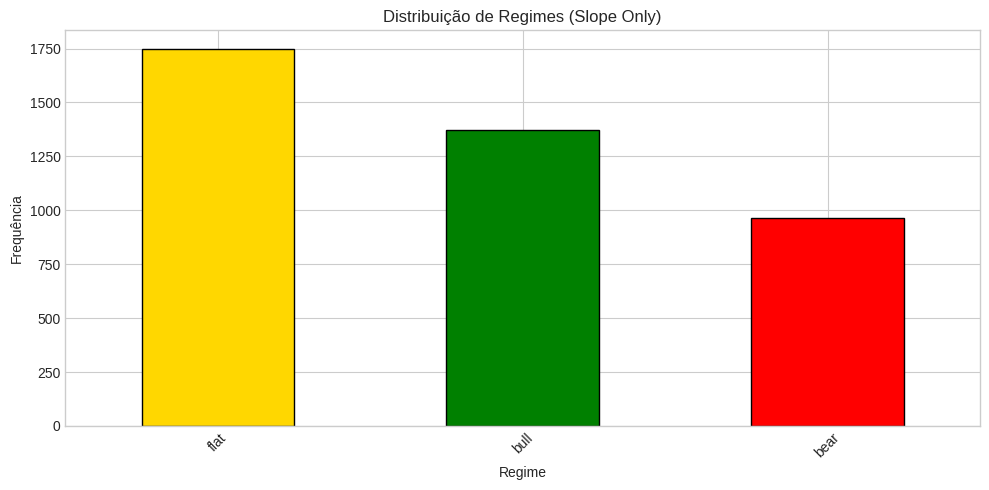

In [15]:
# Visualizar distribuição por regime
regime_counts = df_manual['regime'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))

# Cores para ambos os casos: 6 regimes (com volatilidade) ou 3 regimes (slope only)
colors = {
    # 6 regimes (ManualRegimeClassifier)
    'bull_high_vol': 'lightgreen',
    'bull_low_vol': 'darkgreen',
    'bear_high_vol': 'lightcoral',
    'bear_low_vol': 'darkred',
    'flat_high_vol': 'yellow',
    'flat_low_vol': 'gold',
    # 3 regimes (SlopeOnlyClassifier)
    'bull': 'green',
    'bear': 'red',
    'flat': 'gold'
}
bar_colors = [colors.get(r, 'gray') for r in regime_counts.index]
regime_counts.plot(kind='bar', ax=ax, color=bar_colors, edgecolor='black')

title = 'Distribuição de Regimes (com Volatilidade)' if USE_VOLATILITY else 'Distribuição de Regimes (Slope Only)'
ax.set_title(title)
ax.set_xlabel('Regime')
ax.set_ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Etapa 8: Classificação com K-Means

K-Means detecta regimes automaticamente baseado em múltiplas features.

Isso é mais robusto que thresholds manuais pois considera todas as features simultaneamente.

In [16]:
from src.analysis.kmeans_regimes import KMeansRegimeClassifier

# =============================================================================
# Helper function: Obter colunas de features ativas baseadas na configuração
# =============================================================================
def get_active_feature_columns():
    """
    Retorna lista de colunas de features baseada nos indicadores ativos.
    Esta função é usada pelo K-Means e pelos Explainers.
    """
    features = [f'slope_{config.analysis.window_slope}']  # Slope é sempre incluído
    
    if USE_VOLATILITY:
        features.append(f'volatility_{config.analysis.window_volatility}')
    
    if USE_ROLLING_RETURN:
        features.append(f'log_return_rolling_{config.analysis.window_rolling_return}')
    
    if USE_MA_DISTANCE:
        features.append(f'ma_dist_{config.analysis.ma_fast_period}_{config.analysis.ma_slow_period}')
    
    if USE_TREND_INDICATOR:
        # Usar trend_strength (abs) para evitar redundância com slope
        features.append(f'trend_strength_norm_{config.analysis.window_trend_indicator}')
    
    return features

# Obter features ativas
active_features = get_active_feature_columns()
print(f"=== Features Ativas para Clustering ===")
for f in active_features:
    print(f"  - {f}")

# Criar classificador K-Means com features explícitas
kmeans = KMeansRegimeClassifier(
    n_clusters=config.analysis.n_clusters,
    feature_columns=active_features,  # Usar features ativas explicitamente
    logger=logger
)

# Fit e Predict
df_kmeans = kmeans.fit_predict(df_analysis)

print(f"\n=== Classificação K-Means ===")
print(f"Features usadas: {kmeans.feature_columns}")
print(f"Número de clusters: {config.analysis.n_clusters}")
print(f"\nDistribuição de clusters:")
print(df_kmeans['cluster'].value_counts().sort_index())

=== Features Ativas para Clustering ===
  - slope_20
  - ma_dist_9_21

=== Classificação K-Means ===
Features usadas: ['slope_20', 'ma_dist_9_21']
Número de clusters: 6

Distribuição de clusters:
cluster
0.0    1069
1.0     445
2.0    1072
3.0      14
4.0    1231
5.0     250
Name: count, dtype: int64


In [17]:
# Estatísticas por cluster
future_col = f'log_return_future_{config.analysis.future_return_periods}'
stats = kmeans.compute_statistics(df_kmeans, future_col)
interpretations = kmeans.interpret_clusters(df_kmeans, slope_col)

print("=== Estatísticas por Cluster ===")
for stat in stats:
    interp = interpretations.get(stat.cluster_id, 'unknown')
    print(f"\nCluster {stat.cluster_id} ({interp.upper()}):")
    print(f"  Observações: {stat.count} ({stat.percentage:.1f}%)")
    print(f"  Retorno futuro médio: {stat.future_return_mean:.4f}")
    print(f"  Desvio padrão: {stat.future_return_std:.4f}")
    print(f"  Features médias: {stat.feature_means}")

=== Estatísticas por Cluster ===

Cluster 0 (BEAR):
  Observações: 1069 (26.2%)
  Retorno futuro médio: 0.0008
  Desvio padrão: 0.0362
  Features médias: {'slope_20': np.float64(-0.0023495841423095045), 'ma_dist_9_21': np.float64(0.39764056018933697)}

Cluster 1 (BULL):
  Observações: 445 (10.9%)
  Retorno futuro médio: 0.0008
  Desvio padrão: 0.0281
  Features médias: {'slope_20': np.float64(0.005426980588074133), 'ma_dist_9_21': np.float64(0.7380734477921128)}

Cluster 2 (BULL):
  Observações: 1072 (26.3%)
  Retorno futuro médio: 0.0048
  Desvio padrão: 0.0340
  Features médias: {'slope_20': np.float64(0.002784483641103453), 'ma_dist_9_21': np.float64(0.6054562775791165)}

Cluster 3 (BEAR):
  Observações: 14 (0.3%)
  Retorno futuro médio: 0.0176
  Desvio padrão: 0.0865
  Features médias: {'slope_20': np.float64(-0.02578642208263054), 'ma_dist_9_21': np.float64(-0.6906241205091319)}

Cluster 4 (FLAT):
  Observações: 1231 (30.2%)
  Retorno futuro médio: 0.0017
  Desvio padrão: 0.0344
 

## Etapa 8b: Explicando os Clusters

Usamos Decision Tree e Random Forest para entender quais variáveis são mais importantes para definir cada cluster.

Isso ajuda a interpretar o que o K-Means "aprendeu" sobre os regimes de mercado.

In [18]:
from src.analysis import CompositeExplainer, DecisionTreeExplainer

# Criar explainer composto (Decision Tree + Random Forest)
explainer = CompositeExplainer(
    tree_max_depth=5,           # Profundidade da árvore (interpretabilidade)
    forest_n_estimators=100,    # Número de árvores no Random Forest
    min_samples_leaf=20         # Mínimo de amostras por folha
)

# Usar as mesmas features ativas do K-Means (definidas em get_active_feature_columns)
feature_cols = active_features  # Usa a variável definida na célula do K-Means
print(f"Features usadas pelo Explainer: {feature_cols}")

# Fit no DataFrame com clusters
explainer.fit(df_kmeans, cluster_column='cluster', feature_columns=feature_cols)

# Sumário completo
explainer.print_summary()

Features usadas pelo Explainer: ['slope_20', 'ma_dist_9_21']
CLUSTER EXPLAINER SUMMARY

Dataset: 4081 samples, 2 features, 6 clusters

--- Decision Tree ---
  Train Accuracy: 95.9%
  CV Accuracy:    93.2% (+/- 0.8%)

--- Random Forest ---
  Train Accuracy: 98.4%
  CV Accuracy:    96.3% (+/- 0.7%)

--- Top Features (averaged) ---
  slope_20: 0.642
  ma_dist_9_21: 0.358

--- Decision Tree Rules ---
=== Decision Tree Rules (acc=95.9%) ===


Cluster 0:
  Rule 1: IF slope_20 <= 0.0014 AND slope_20 <= -0.0010 AND slope_20 <= -0.0047 AND slope_20 > -0.0095 AND ma_dist_9_21 > 0.3501
           THEN cluster = 0 (n=1, acc=65.0%)
  Rule 2: IF slope_20 <= 0.0014 AND slope_20 <= -0.0010 AND slope_20 > -0.0047 AND ma_dist_9_21 > 0.2868 AND ma_dist_9_21 <= 0.4513
           THEN cluster = 0 (n=1, acc=98.9%)
  Rule 3: IF slope_20 <= 0.0014 AND slope_20 <= -0.0010 AND slope_20 > -0.0047 AND ma_dist_9_21 > 0.2868 AND ma_dist_9_21 > 0.4513
           THEN cluster = 0 (n=1, acc=52.5%)
  Rule 4: IF slope_2

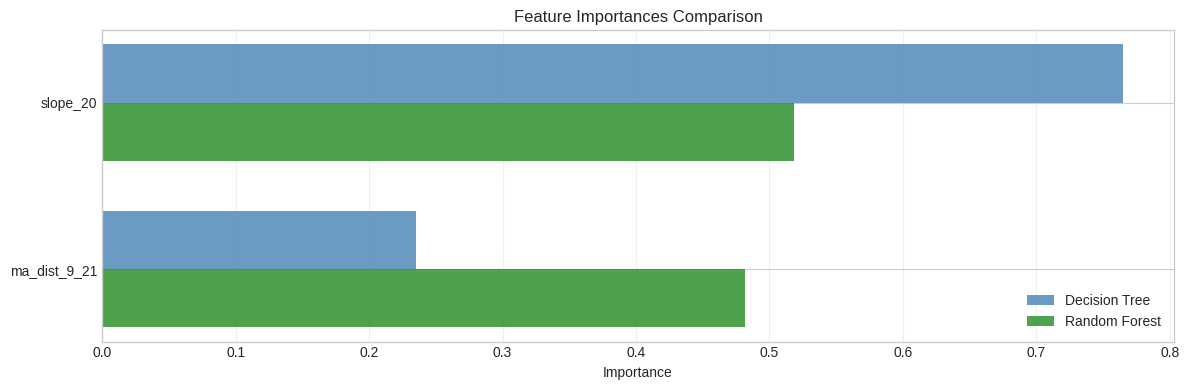

In [19]:
# Comparar importâncias: Decision Tree vs Random Forest
fig = explainer.plot_importances()
plt.show()

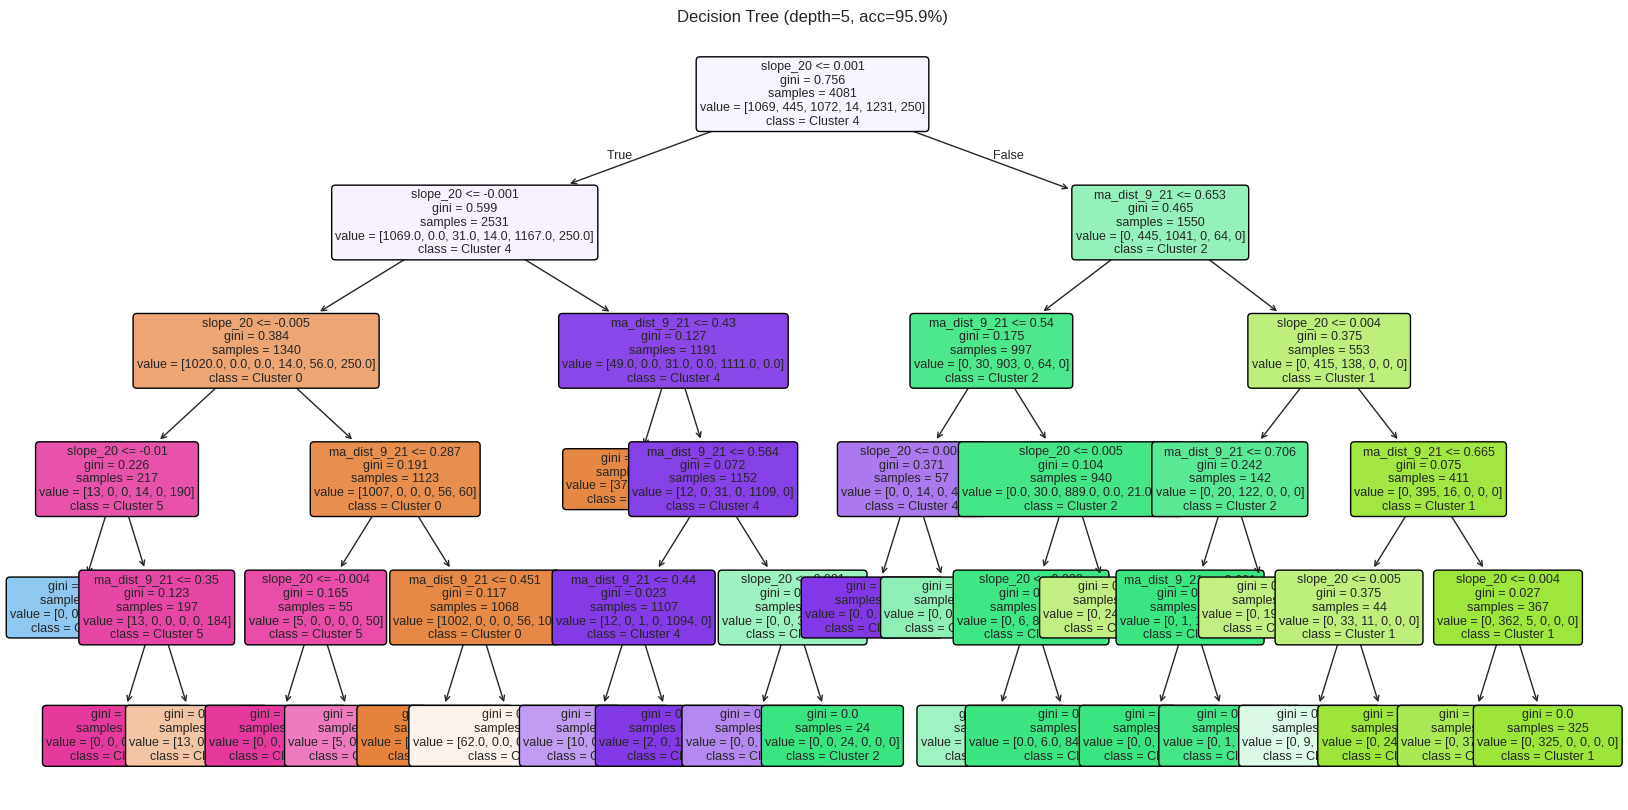

In [20]:
# Visualizar a árvore de decisão
fig = explainer.plot_tree(figsize=(20, 10), fontsize=9)
plt.show()

In [21]:
# Top 3 features mais importantes
print("=== Top 3 Features ===")
for feature, importance in explainer.get_top_features(3):
    print(f"  {feature}: {importance:.3f}")

# Métricas do modelo
metrics = explainer.get_metrics()
print(f"\n=== Métricas ===")
print(f"  Accuracy (train): {metrics.accuracy:.1%}")
print(f"  Accuracy (CV):    {metrics.cv_accuracy_mean:.1%} (+/- {metrics.cv_accuracy_std:.1%})")
print(f"  Samples:          {metrics.n_samples}")
print(f"  Clusters:         {metrics.n_clusters}")

=== Top 3 Features ===
  slope_20: 0.642
  ma_dist_9_21: 0.358

=== Métricas ===
  Accuracy (train): 98.4%
  Accuracy (CV):    96.3% (+/- 0.7%)
  Samples:          4081
  Clusters:         6


## Etapa 9: Cálculo de Probabilidades

Agora calculamos a probabilidade de atingir o retorno alvo, condicionada por regime.

In [22]:
from src.analysis.probability_calculator import ProbabilityCalculator

# Usando classificação manual
prob_calc_manual = ProbabilityCalculator(
    future_return_column=future_col,
    target_return=config.analysis.target_return,
    regime_column='regime'
)

# Gerar relatório completo
report = prob_calc_manual.generate_report(df_manual)

print("=== Relatório de Probabilidades (Regimes Manuais) ===")
print(f"\nRetorno alvo: {report['target_return']:.1%}")
print(f"Log-retorno alvo: {report['log_target']:.4f}")
print(f"\nProbabilidade incondicional: {report['raw_probability_pct']:.2f}%")

print(f"\nProbabilidades condicionais:")
for regime, data in report['conditional_probabilities'].items():
    print(f"  {regime}:")
    print(f"    P(hit) = {data['probability_pct']:.2f}%")
    print(f"    n = {data['count']}")
    print(f"    retorno médio = {data['mean_return']:.4f}")

print(f"\nMétricas de separação:")
print(f"  Delta P: {report['separation_metrics']['delta_p']:.4f}")
print(f"  (diferença entre maior e menor probabilidade)")
print(f"  Information Ratio: {report['separation_metrics']['information_ratio']:.4f}")

=== Relatório de Probabilidades (Regimes Manuais) ===

Retorno alvo: 5.0%
Log-retorno alvo: 0.0488

Probabilidade incondicional: 7.99%

Probabilidades condicionais:
  bull:
    P(hit) = 5.35%
    n = 1364
    retorno médio = 0.0035
  flat:
    P(hit) = 8.01%
    n = 1747
    retorno médio = 0.0021
  bear:
    P(hit) = 10.89%
    n = 964
    retorno médio = -0.0009

Métricas de separação:
  Delta P: 0.0554
  (diferença entre maior e menor probabilidade)
  Information Ratio: 0.1194


In [23]:
# Usando classificação K-Means
prob_calc_kmeans = ProbabilityCalculator(
    future_return_column=future_col,
    target_return=config.analysis.target_return,
    regime_column='cluster'
)

report_kmeans = prob_calc_kmeans.generate_report(df_kmeans)

print("=== Relatório de Probabilidades (K-Means) ===")
print(f"\nRetorno alvo: {report_kmeans['target_return']:.1%}")
print(f"\nProbabilidade incondicional: {report_kmeans['raw_probability_pct']:.2f}%")

print(f"\nProbabilidades por cluster:")
for cluster_id, data in sorted(report_kmeans['conditional_probabilities'].items()):
    interp = interpretations.get(int(float(cluster_id)), 'unknown')
    print(f"  Cluster {cluster_id} ({interp}): P(hit) = {data['probability_pct']:.2f}% (n={data['count']})")

print(f"\nDelta P: {report_kmeans['separation_metrics']['delta_p']:.4f}")

=== Relatório de Probabilidades (K-Means) ===

Retorno alvo: 5.0%

Probabilidade incondicional: 7.99%

Probabilidades por cluster:
  Cluster 0.0 (bear): P(hit) = 9.26% (n=1069)
  Cluster 1.0 (bull): P(hit) = 2.26% (n=442)
  Cluster 2.0 (bull): P(hit) = 6.65% (n=1068)
  Cluster 3.0 (bear): P(hit) = 50.00% (n=14)
  Cluster 4.0 (flat): P(hit) = 7.88% (n=1231)
  Cluster 5.0 (bear): P(hit) = 13.60% (n=250)

Delta P: 0.4774


## Etapa 10: Visualizações

Visualizamos a distribuição de retornos por regime.

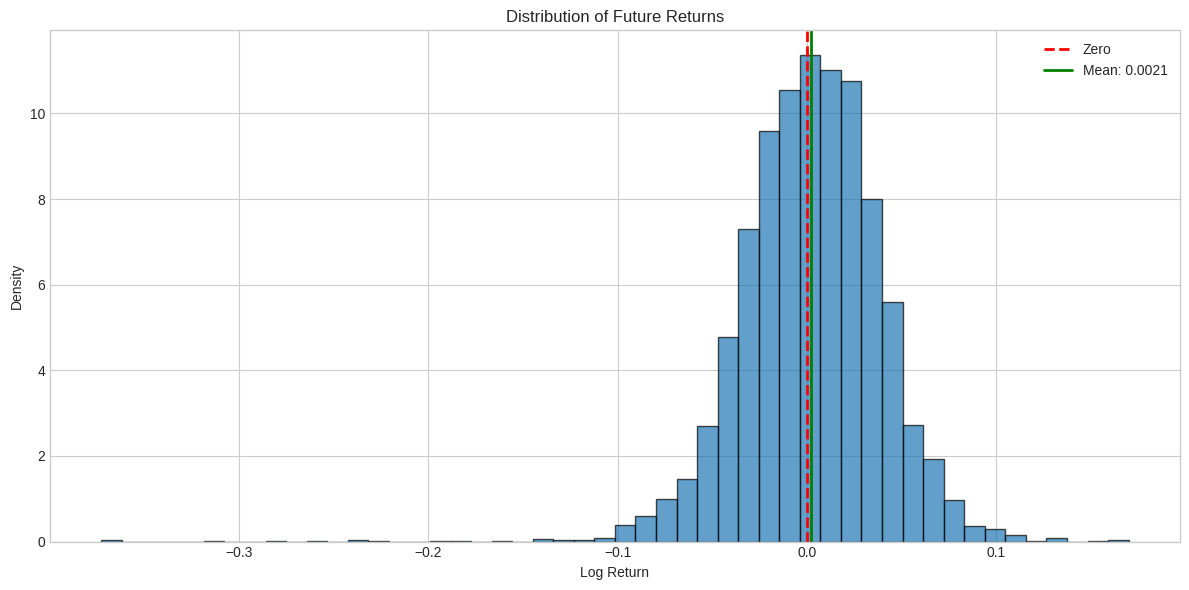

In [24]:
from src.visualization.histogram_plotter import HistogramPlotter, PriceRegimePlotter

# Histograma geral
hist_plotter = HistogramPlotter(
    return_column=future_col,
    regime_column='regime'
)

fig = hist_plotter.plot(df_manual)
plt.show()

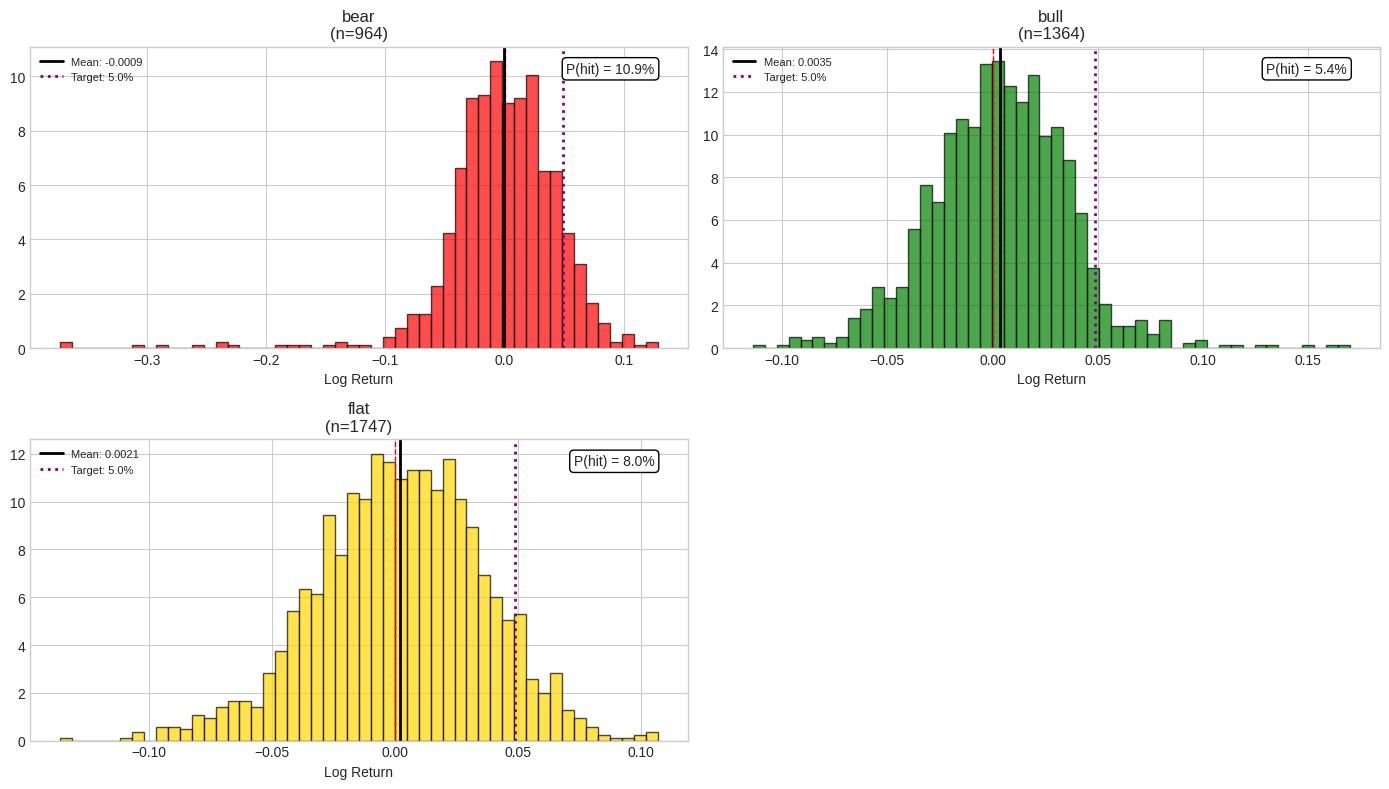

In [25]:
# Histogramas por regime
fig = hist_plotter.plot_by_regime(df_manual, target_return=config.analysis.target_return)
plt.show()

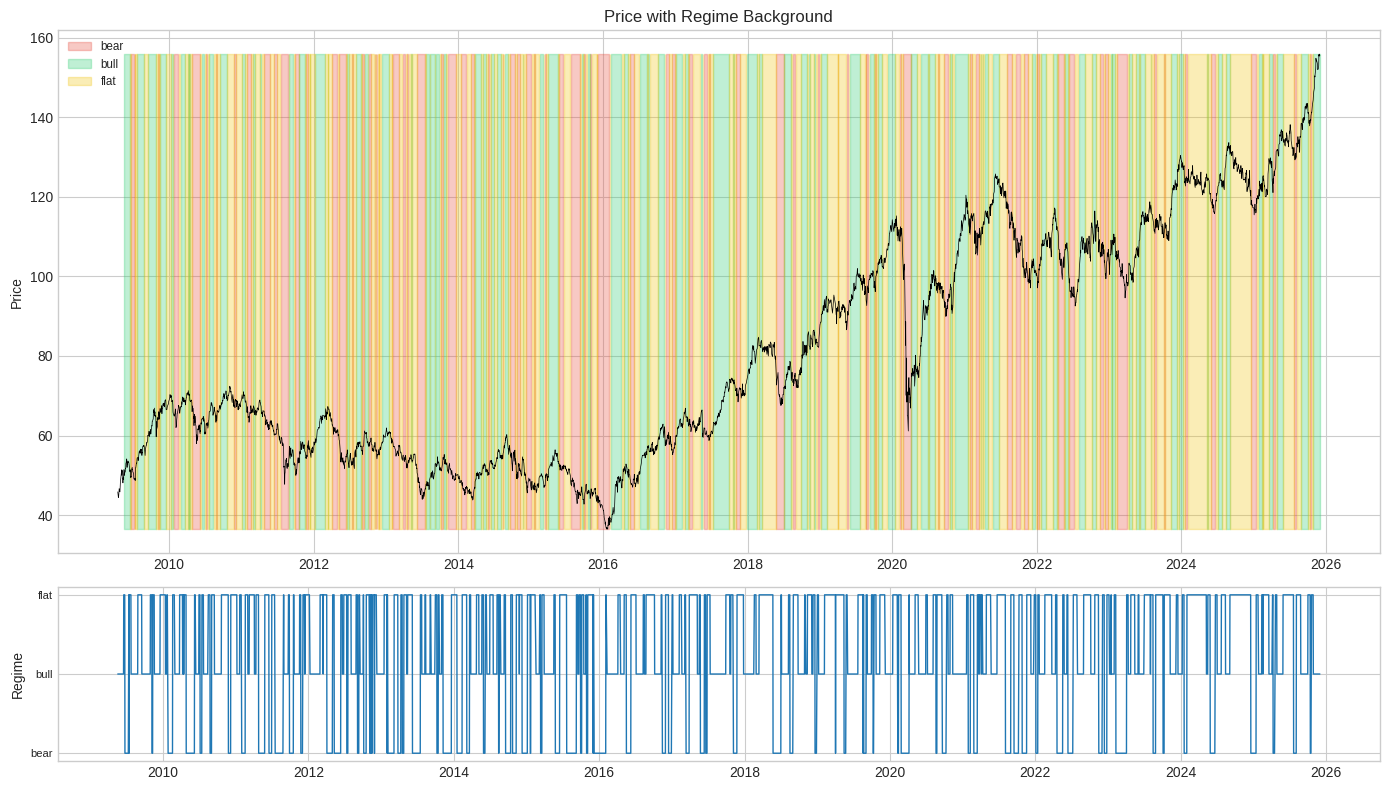

In [26]:
# Preço com background de regime
df_manual_indexed = df_manual.set_index('date')

price_plotter = PriceRegimePlotter(regime_column='regime')
fig = price_plotter.plot(df_manual_indexed)
plt.show()

## Etapa 11: Walk-Forward Validation

Para evitar overfitting, usamos walk-forward validation.

Isso simula como o modelo performaria em tempo real, sempre treinando no passado e testando no futuro.

In [27]:
from src.analysis.time_series_splitter import TimeSeriesSplitter

# Criar splitter
splitter = TimeSeriesSplitter(train_ratio=0.7)

# Demonstrar walk-forward splits
print("=== Walk-Forward Splits ===")
for split in splitter.walk_forward_split(df, n_folds=5, min_train_size=252):
    train_start = split.train['date'].min().date()
    train_end = split.train['date'].max().date()
    test_start = split.test['date'].min().date()
    test_end = split.test['date'].max().date()
    
    print(f"\nFold {split.fold}:")
    print(f"  Train: {train_start} a {train_end} ({len(split.train)} obs)")
    print(f"  Test:  {test_start} a {test_end} ({len(split.test)} obs)")

=== Walk-Forward Splits ===

Fold 0:
  Train: 2009-04-17 a 2010-04-28 (252 obs)
  Test:  2010-04-29 a 2013-06-07 (769 obs)

Fold 1:
  Train: 2009-04-17 a 2013-06-07 (1021 obs)
  Test:  2013-06-10 a 2016-07-18 (769 obs)

Fold 2:
  Train: 2009-04-17 a 2016-07-18 (1790 obs)
  Test:  2016-07-19 a 2019-09-20 (769 obs)

Fold 3:
  Train: 2009-04-17 a 2019-09-20 (2559 obs)
  Test:  2019-09-23 a 2022-10-27 (769 obs)

Fold 4:
  Train: 2009-04-17 a 2022-10-27 (3328 obs)
  Test:  2022-10-28 a 2025-11-25 (769 obs)


## Etapa 12: Otimização com Algoritmo Genético (Otimizado)

O GA busca os melhores parâmetros automaticamente.

**Otimizações implementadas:**
1. **Paralelização**: Avaliação de fitness usa múltiplos cores CPU
2. **Cache**: Cromossomos idênticos não são reavaliados
3. **Numba**: Cálculo de slope ~10-50x mais rápido (após warm-up)
4. **KMeans otimizado**: Algoritmo Lloyd para melhor performance

**NOTA sobre Numba**: A primeira execução será mais lenta devido à compilação JIT. Execuções subsequentes serão significativamente mais rápidas. O cache do Numba persiste entre sessões.

**NOTA**: Esta etapa é computacionalmente intensiva. Reduzimos os parâmetros para demonstração.

In [28]:
from src.calculators.slope_calculator import SlopeCalculator
import multiprocessing as mp

# Verificar otimizações disponíveis
print("=== Verificação de Otimizações ===")
print(f"Numba disponível para SlopeCalculator: {SlopeCalculator.is_numba_available()}")
print(f"CPUs disponíveis para paralelização: {mp.cpu_count()}")

# ga_config já definido na célula de configuração centralizada
print("\n=== Configuração do GA (da célula centralizada) ===")
print(f"Target Return: {ga_config.target_return:.1%}")
print(f"Horizonte: {ga_config.horizon} dias")
print(f"População: {ga_config.population_size}")
print(f"Gerações: {ga_config.generations}")
print(f"Folds: {ga_config.n_folds}")
print(f"Early Stopping: {ga_config.early_stopping}")

# Estimativa de tempo
tempo_por_gen = ga_config.population_size * 0.035  # ~0.035s por cromossomo
tempo_total = ga_config.generations * tempo_por_gen
print(f"\nTempo estimado: {tempo_total/60:.1f} minutos")
print("\nNOTA: Use Ctrl+C para interromper e salvar checkpoint a qualquer momento.")

=== Verificação de Otimizações ===
Numba disponível para SlopeCalculator: True
CPUs disponíveis para paralelização: 12

=== Configuração do GA (da célula centralizada) ===
Target Return: 3.0%
Horizonte: 7 dias
População: 100
Gerações: 1000
Folds: 3
Early Stopping: True

Tempo estimado: 58.3 minutos

NOTA: Use Ctrl+C para interromper e salvar checkpoint a qualquer momento.


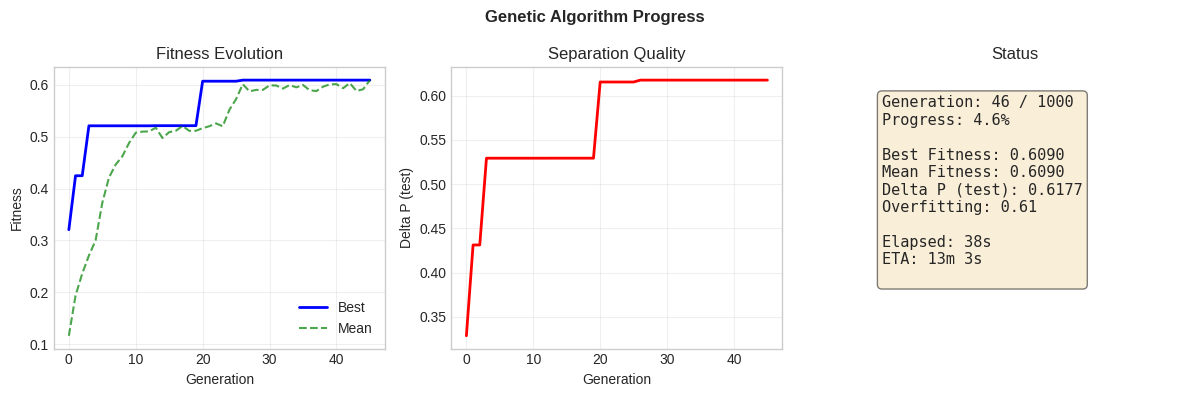

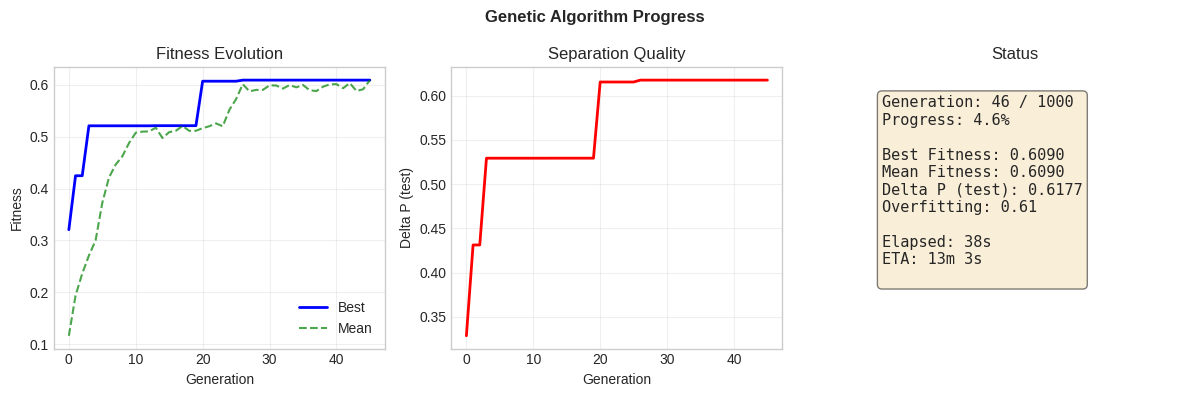


=== Melhores Parâmetros Encontrados ===
  Window Slope: 51
  N Clusters: 5
  MA Fast Period: 5
  MA Slow Period: 26

Indicadores ativos:
  ❌ Volatility
  ❌ Rolling Return
  ✅ MA Distance
  ❌ Trend Indicator

Parâmetros fixos (da configuração):
  Target Return: 3.00%
  Horizon: 7 dias

Métricas:
  Fitness: 0.6090
  Delta P (test): 0.6177
  Overfitting Ratio: 0.61

Estatísticas:
  Total avaliações: 4600


In [29]:
from src.optimization.genetic_algorithm import GeneticAlgorithm, GACheckpoint
from src.optimization.progress_callback import LiveProgressCallback

# Criar callback de progresso visual
progress_callback = LiveProgressCallback(
    total_generations=ga_config.generations,
    population_size=ga_config.population_size,
    update_every=1
)

# Executar GA
# NOTA: parallel=False é mais estável em Jupyter notebooks
ga = GeneticAlgorithm(
    df, 
    ga_config, 
    logger=logger,
    progress_callback=progress_callback,
    n_workers=None
)

try:
    result = ga.run(
        verbose=False,
        parallel=False,  # Desativado para evitar problemas no Jupyter
        auto_checkpoint_path="ga_checkpoint.json",
        checkpoint_every=10
    )
except KeyboardInterrupt:
    print("\nInterrompido! Salvando checkpoint...")
    ga.save_checkpoint("ga_checkpoint.json")
    print("Checkpoint salvo em 'ga_checkpoint.json'")
    print("Para retomar: checkpoint = GACheckpoint.load('ga_checkpoint.json')")
    raise

progress_callback.finalize()

print("\n=== Melhores Parâmetros Encontrados ===")
best = result.best_chromosome

# Parâmetros sempre ativos
print(f"  Window Slope: {best.window_slope}")
print(f"  N Clusters: {best.n_clusters}")

# Parâmetros condicionais (só mostrar se indicador está ativo)
if best.use_volatility:
    print(f"  Window Volatility: {best.window_volatility}")
if best.use_rolling_return:
    print(f"  Window Rolling Return: {best.window_rolling_return}")
if best.use_ma_distance:
    print(f"  MA Fast Period: {best.ma_fast_period}")
    print(f"  MA Slow Period: {best.ma_slow_period}")
if best.use_trend_indicator:
    print(f"  Window Trend Indicator: {best.window_trend_indicator}")
    print(f"  Trend Slope Multiplier: {best.trend_slope_multiplier}")

# Mostrar quais indicadores estão ativos
print(f"\nIndicadores ativos:")
print(f"  {'✅' if best.use_volatility else '❌'} Volatility")
print(f"  {'✅' if best.use_rolling_return else '❌'} Rolling Return")
print(f"  {'✅' if best.use_ma_distance else '❌'} MA Distance")
print(f"  {'✅' if best.use_trend_indicator else '❌'} Trend Indicator")

print(f"\nParâmetros fixos (da configuração):")
print(f"  Target Return: {ga_config.target_return:.2%}")
print(f"  Horizon: {ga_config.horizon} dias")

print(f"\nMétricas:")
print(f"  Fitness: {result.best_fitness:.4f}")
print(f"  Delta P (test): {result.best_metrics.delta_p_test:.4f}")
print(f"  Overfitting Ratio: {result.best_metrics.overfitting_ratio:.2f}")

print(f"\nEstatísticas:")
print(f"  Total avaliações: {result.all_evaluations}")

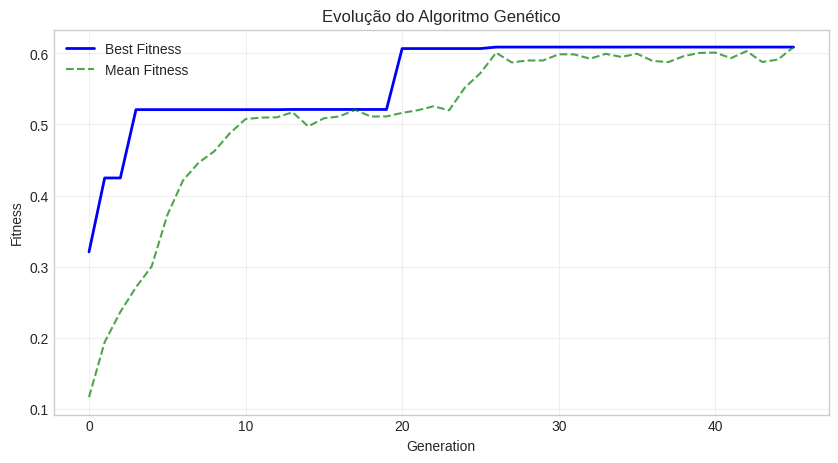

In [30]:
# Plotar evolução do fitness
generations = [h[0] for h in result.history]
best_fitness = [h[1] for h in result.history]
mean_fitness = [h[2] for h in result.history]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(generations, best_fitness, 'b-', label='Best Fitness', linewidth=2)
ax.plot(generations, mean_fitness, 'g--', label='Mean Fitness', alpha=0.7)
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_title('Evolução do Algoritmo Genético')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Etapa 13: Aplicar Melhores Parâmetros

Agora aplicamos os parâmetros otimizados e recalculamos as probabilidades.

In [31]:
from src.optimization.calculator_factory import CalculatorFactory

# Factory para criar pipeline com os melhores parâmetros
# horizon vem da configuração, não do cromossomo
factory = CalculatorFactory(horizon=ga_config.horizon)
best_pipeline = factory.create_pipeline(best)
feature_cols = factory.get_feature_columns(best)
future_col_best = factory.get_future_return_column()

# Processar dados
df_best = best_pipeline.run(df)

# Clustering
best_kmeans = KMeansRegimeClassifier(
    n_clusters=best.n_clusters,
    feature_columns=feature_cols
)
df_best = best_kmeans.fit_predict(df_best)

# Probabilidades (target_return vem da configuração)
best_prob = ProbabilityCalculator(
    future_return_column=future_col_best,
    target_return=ga_config.target_return,
    regime_column='cluster'
)

best_report = best_prob.generate_report(df_best)

print("=== Relatório com Parâmetros Otimizados ===")
print(f"\nRetorno alvo: {ga_config.target_return:.1%}")
print(f"Horizonte: {ga_config.horizon} dias")
print(f"\nProbabilidade incondicional: {best_report['raw_probability_pct']:.2f}%")

# Interpretar clusters
slope_col_best = f'slope_{best.window_slope}'
best_interp = best_kmeans.interpret_clusters(df_best, slope_col_best)

print(f"\nProbabilidades por cluster:")
for cluster_id, data in sorted(best_report['conditional_probabilities'].items()):
    interp = best_interp.get(int(float(cluster_id)), 'unknown')
    print(f"  Cluster {cluster_id} ({interp.upper()}): P(hit) = {data['probability_pct']:.2f}% (n={data['count']})")

print(f"\nDelta P: {best_report['separation_metrics']['delta_p']:.4f}")
print(f"Information Ratio: {best_report['separation_metrics']['information_ratio']:.4f}")

=== Relatório com Parâmetros Otimizados ===

Retorno alvo: 3.0%
Horizonte: 7 dias

Probabilidade incondicional: 21.28%

Probabilidades por cluster:
  Cluster 0.0 (BEAR): P(hit) = 24.34% (n=867)
  Cluster 1.0 (BEAR): P(hit) = 22.56% (n=922)
  Cluster 2.0 (BULL): P(hit) = 17.52% (n=1136)
  Cluster 3.0 (BULL): P(hit) = 20.31% (n=1098)
  Cluster 4.0 (BEAR): P(hit) = 71.43% (n=21)

Delta P: 0.5391
Information Ratio: 0.1530


In [32]:
# Explicar clusters dos parâmetros otimizados
from src.analysis import CompositeExplainer

best_explainer = CompositeExplainer(
    tree_max_depth=5,
    forest_n_estimators=100,
    min_samples_leaf=20
)

# Fit no DataFrame com clusters otimizados
best_explainer.fit(df_best, cluster_column='cluster', feature_columns=feature_cols)

# Sumário
print("=== Explicação dos Clusters (Parâmetros Otimizados) ===")
best_explainer.print_summary()

=== Explicação dos Clusters (Parâmetros Otimizados) ===
CLUSTER EXPLAINER SUMMARY

Dataset: 4051 samples, 2 features, 5 clusters

--- Decision Tree ---
  Train Accuracy: 96.6%
  CV Accuracy:    94.0% (+/- 1.4%)

--- Random Forest ---
  Train Accuracy: 98.3%
  CV Accuracy:    96.3% (+/- 0.8%)

--- Top Features (averaged) ---
  ma_dist_5_26: 0.576
  slope_51: 0.424

--- Decision Tree Rules ---
=== Decision Tree Rules (acc=96.6%) ===


Cluster 0:
  Rule 1: IF slope_51 <= 0.0001 AND ma_dist_5_26 > 0.4221 AND ma_dist_5_26 <= 0.4398 AND slope_51 <= -0.0004 AND slope_51 > -0.0024
           THEN cluster = 0 (n=1, acc=93.6%)
  Rule 2: IF slope_51 <= 0.0001 AND ma_dist_5_26 > 0.4221 AND ma_dist_5_26 > 0.4398 AND slope_51 <= -0.0000 AND slope_51 <= -0.0002
           THEN cluster = 0 (n=1, acc=99.1%)
  Rule 3: IF slope_51 <= 0.0001 AND ma_dist_5_26 > 0.4221 AND ma_dist_5_26 > 0.4398 AND slope_51 <= -0.0000 AND slope_51 > -0.0002
           THEN cluster = 0 (n=1, acc=84.7%)
  Rule 4: IF slope_51 

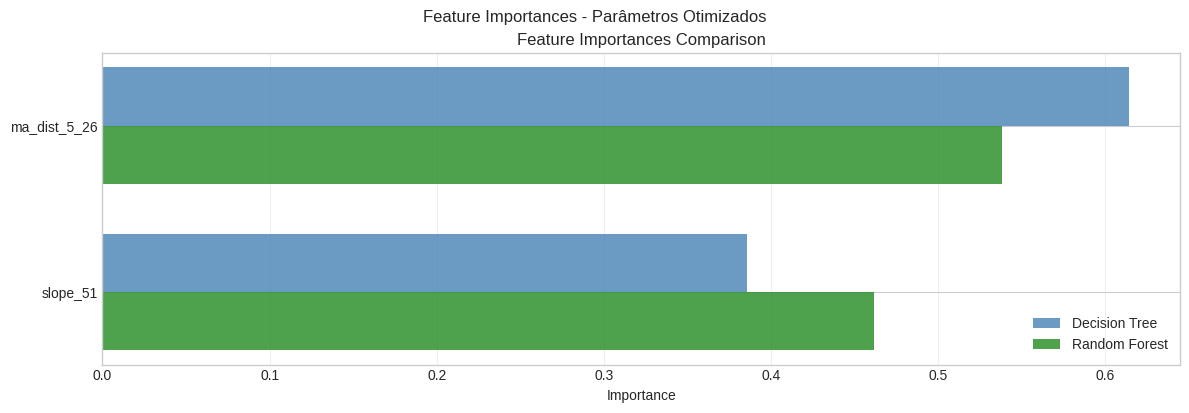

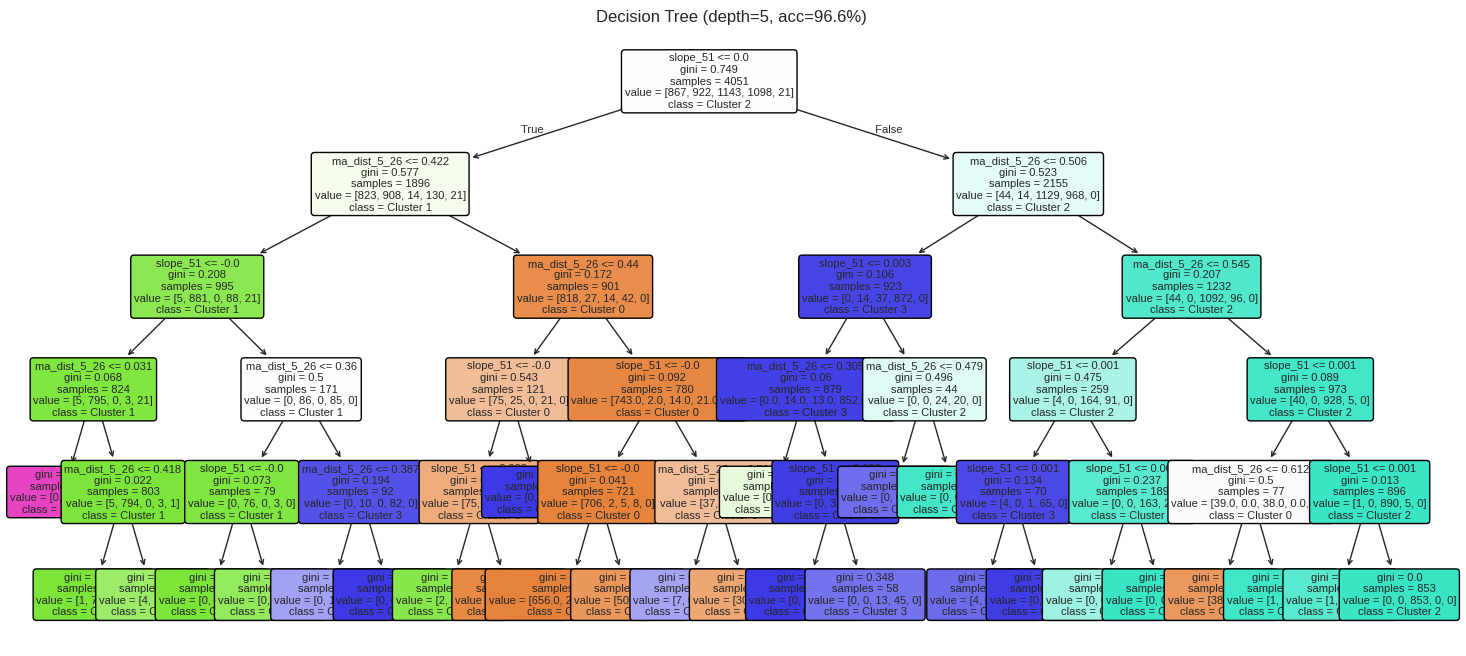

In [33]:
# Visualizar importâncias e árvore (parâmetros otimizados)
fig = best_explainer.plot_importances()
plt.suptitle('Feature Importances - Parâmetros Otimizados', y=1.02)
plt.show()

# Visualizar árvore de decisão
fig = best_explainer.plot_tree(figsize=(18, 8), fontsize=8)
plt.show()

## Etapa 14: Visualizações com Parâmetros Otimizados

Agora repetimos todas as visualizações usando os parâmetros do indivíduo vencedor do GA.

In [34]:
# Estatísticas por cluster com parâmetros otimizados
stats_best = best_kmeans.compute_statistics(df_best, future_col_best)

print("=== Estatísticas por Cluster (Parâmetros Otimizados) ===")
for stat in stats_best:
    interp = best_interp.get(stat.cluster_id, 'unknown')
    print(f"\nCluster {stat.cluster_id} ({interp.upper()}):")
    print(f"  Observações: {stat.count} ({stat.percentage:.1f}%)")
    print(f"  Retorno futuro médio: {stat.future_return_mean:.4f}")
    print(f"  Desvio padrão: {stat.future_return_std:.4f}")
    print(f"  Features médias: {stat.feature_means}")

=== Estatísticas por Cluster (Parâmetros Otimizados) ===

Cluster 0 (BEAR):
  Observações: 867 (21.4%)
  Retorno futuro médio: 0.0033
  Desvio padrão: 0.0386
  Features médias: {'slope_51': np.float64(-0.0013358105901415966), 'ma_dist_5_26': np.float64(0.519552350124021)}

Cluster 1 (BEAR):
  Observações: 922 (22.8%)
  Retorno futuro médio: -0.0003
  Desvio padrão: 0.0446
  Features médias: {'slope_51': np.float64(-0.0016910612143062084), 'ma_dist_5_26': np.float64(0.3267790772990707)}

Cluster 2 (BULL):
  Observações: 1143 (28.2%)
  Retorno futuro médio: 0.0025
  Desvio padrão: 0.0286
  Features médias: {'slope_51': np.float64(0.0023217051044718763), 'ma_dist_5_26': np.float64(0.6199780833512485)}

Cluster 3 (BULL):
  Observações: 1098 (27.1%)
  Retorno futuro médio: 0.0021
  Desvio padrão: 0.0335
  Features médias: {'slope_51': np.float64(0.0011931604227636314), 'ma_dist_5_26': np.float64(0.43119462380126605)}

Cluster 4 (BEAR):
  Observações: 21 (0.5%)
  Retorno futuro médio: 0.0054

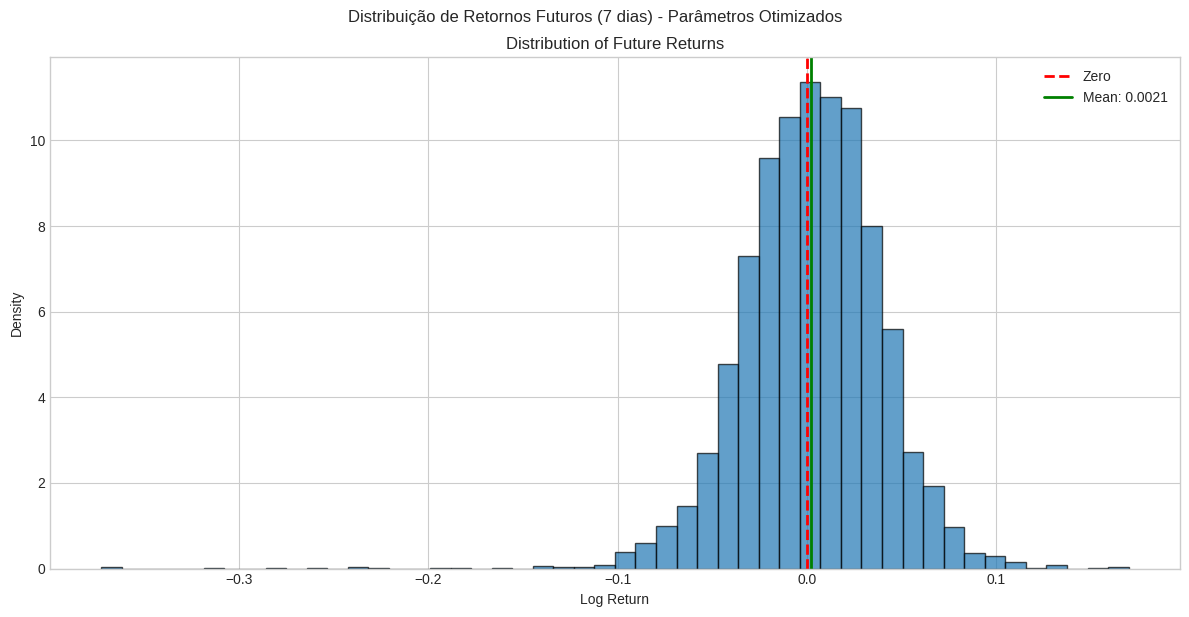

In [35]:
# Histograma de retornos com parâmetros otimizados
hist_plotter_best = HistogramPlotter(
    return_column=future_col_best,
    regime_column='cluster'
)

fig = hist_plotter_best.plot(df_best)
plt.suptitle(f'Distribuição de Retornos Futuros ({ga_config.horizon} dias) - Parâmetros Otimizados', y=1.02)
plt.show()

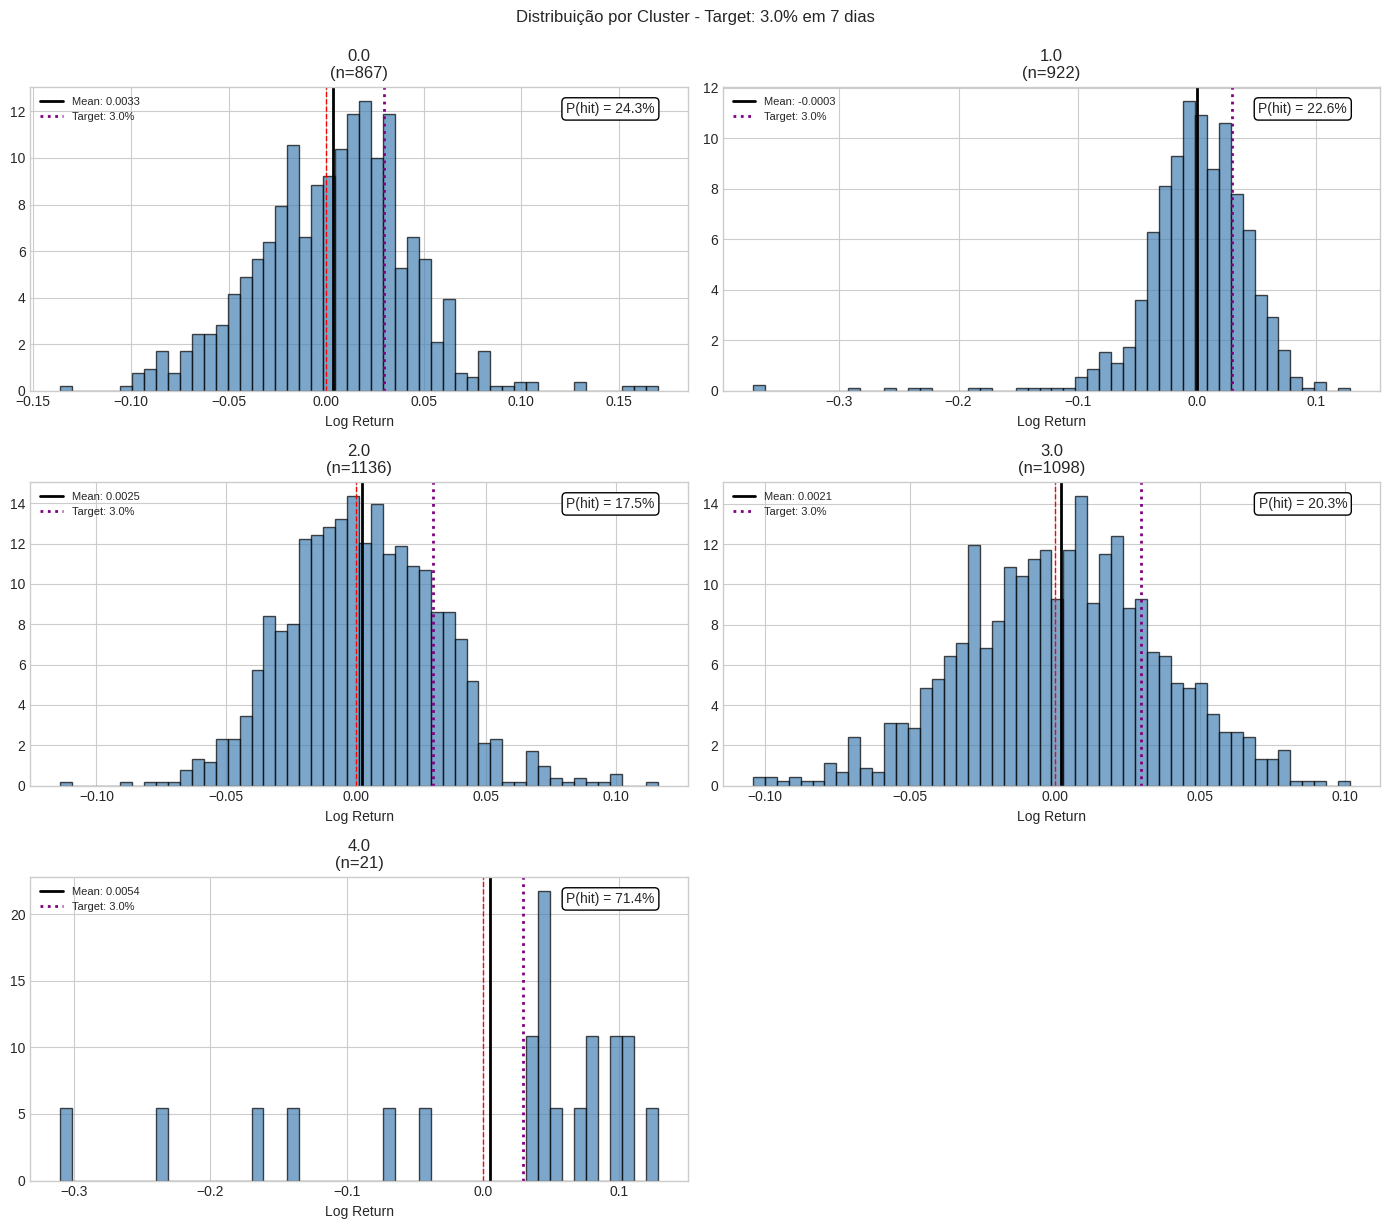

In [36]:
# Histogramas por cluster com linha do target
fig = hist_plotter_best.plot_by_regime(df_best, target_return=ga_config.target_return)
plt.suptitle(f'Distribuição por Cluster - Target: {ga_config.target_return:.1%} em {ga_config.horizon} dias', y=1.02)
plt.show()

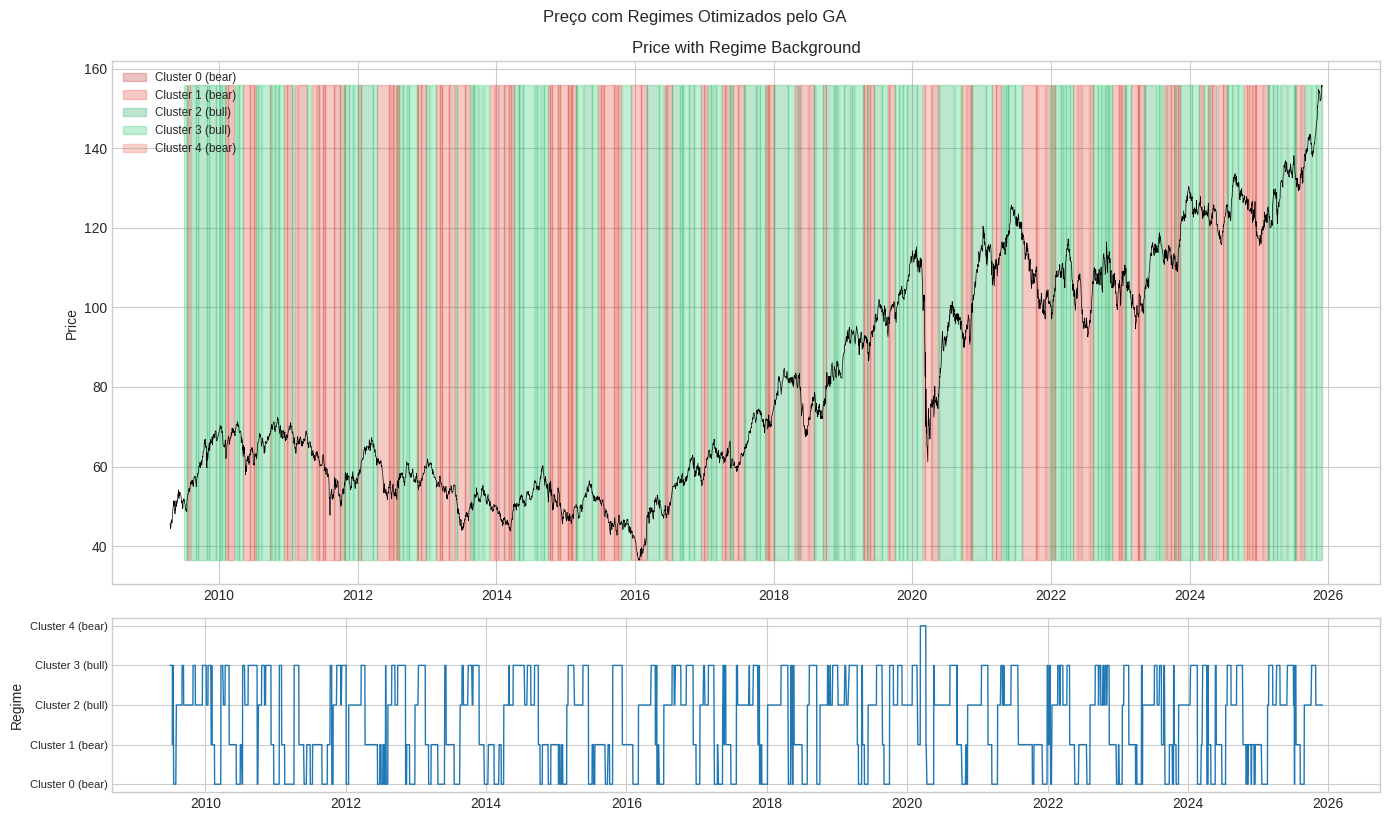

In [37]:
# Preço com background de cluster otimizado
df_best_indexed = df_best.set_index('date')

price_plotter_best = PriceRegimePlotter(regime_column='cluster')
fig = price_plotter_best.plot(df_best_indexed, cluster_interpretations=best_interp)
plt.suptitle('Preço com Regimes Otimizados pelo GA', y=1.02)
plt.show()

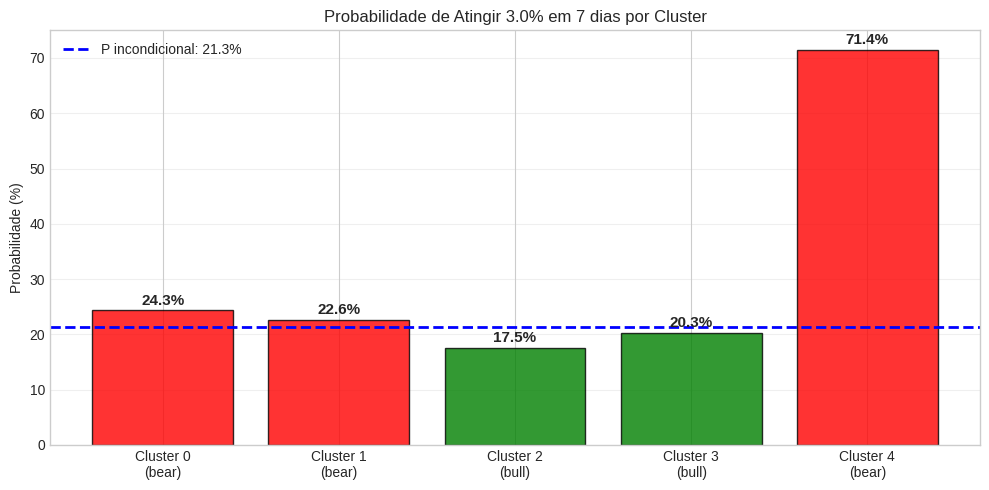


Delta P (separação): 0.5391
Melhor cluster: 4.0
Pior cluster: 2.0


In [38]:
# Gráfico de barras: Probabilidade por Cluster
clusters = []
probs = []
colors = []
color_map = {'bull': 'green', 'bear': 'red', 'flat': 'gold'}

for cluster_id, data in sorted(best_report['conditional_probabilities'].items()):
    interp = best_interp.get(int(float(cluster_id)), 'flat')
    clusters.append(f"Cluster {int(float(cluster_id))}\n({interp})")
    probs.append(data['probability_pct'])
    colors.append(color_map.get(interp, 'gray'))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(clusters, probs, color=colors, edgecolor='black', alpha=0.8)

# Linha horizontal para probabilidade incondicional
ax.axhline(y=best_report['raw_probability_pct'], color='blue', linestyle='--', 
           linewidth=2, label=f"P incondicional: {best_report['raw_probability_pct']:.1f}%")

# Adicionar valores nas barras
for bar, prob in zip(bars, probs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{prob:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Probabilidade (%)')
ax.set_title(f'Probabilidade de Atingir {ga_config.target_return:.1%} em {ga_config.horizon} dias por Cluster')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDelta P (separação): {best_report['separation_metrics']['delta_p']:.4f}")
print(f"Melhor cluster: {max(best_report['conditional_probabilities'].items(), key=lambda x: x[1]['probability_pct'])[0]}")
print(f"Pior cluster: {min(best_report['conditional_probabilities'].items(), key=lambda x: x[1]['probability_pct'])[0]}")

In [39]:
# Identificar regime atual e probabilidade
last_row = df_best.iloc[-1]
current_cluster = int(last_row['cluster'])
current_interp = best_interp.get(current_cluster, 'unknown')
current_prob = best_report['conditional_probabilities'][str(float(current_cluster))]['probability_pct']

print("=" * 60)
print("SITUAÇÃO ATUAL")
print("=" * 60)
print(f"\nData mais recente: {last_row['date'].strftime('%Y-%m-%d')}")
print(f"Preço de fechamento: R$ {last_row['close']:.2f}")
print(f"\nRegime atual: Cluster {current_cluster} ({current_interp.upper()})")

# Mostrar indicadores atuais
print(f"\n=== Indicadores Atuais ===")
print(f"  Slope ({best.window_slope}d): {last_row[f'slope_{best.window_slope}']:.6f}")
if best.use_volatility:
    print(f"  Volatility ({best.window_volatility}d): {last_row[f'volatility_{best.window_volatility}']:.4f}")
if best.use_rolling_return:
    print(f"  Log Return Rolling ({best.window_rolling_return}d): {last_row[f'log_return_rolling_{best.window_rolling_return}']:.4f}")
if best.use_ma_distance:
    print(f"  MA Distance ({best.ma_fast_period}/{best.ma_slow_period}): {last_row[f'ma_dist_{best.ma_fast_period}_{best.ma_slow_period}']:.4f}")
if best.use_trend_indicator:
    trend_col = f'trend_indicator_norm_{best.window_trend_indicator}'
    trend_value = last_row[trend_col]
    trend_interpretation = "BULLISH" if trend_value > 0.3 else "BEARISH" if trend_value < -0.3 else "NEUTRAL"
    print(f"  Trend Indicator ({best.window_trend_indicator}d, mult={best.trend_slope_multiplier}): {trend_value:.4f} ({trend_interpretation})")

print(f"\nProbabilidade de atingir {ga_config.target_return:.1%} em {ga_config.horizon} dias:")
print(f"  -> {current_prob:.1f}%")
print(f"\nProbabilidade incondicional (média histórica): {best_report['raw_probability_pct']:.1f}%")

# Comparação
diff = current_prob - best_report['raw_probability_pct']
if diff > 0:
    print(f"\n✅ Regime atual tem probabilidade {diff:.1f} pontos percentuais ACIMA da média")
else:
    print(f"\n⚠️ Regime atual tem probabilidade {abs(diff):.1f} pontos percentuais ABAIXO da média")

SITUAÇÃO ATUAL

Data mais recente: 2025-12-01
Preço de fechamento: R$ 155.50

Regime atual: Cluster 2 (BULL)

=== Indicadores Atuais ===
  Slope (51d): 0.002307
  MA Distance (5/26): 0.6895

Probabilidade de atingir 3.0% em 7 dias:
  -> 17.5%

Probabilidade incondicional (média histórica): 21.3%

⚠️ Regime atual tem probabilidade 3.8 pontos percentuais ABAIXO da média


<cell_type>markdown</cell_type>## Etapa 15: Análise Dual - Fechar vs Tocar

Comparamos duas probabilidades diferentes:
- **P(fechar)**: Probabilidade do preço FECHAR acima do alvo em t+H
- **P(tocar)**: Probabilidade do preço TOCAR o alvo em algum momento entre t+1 e t+H

Esta análise é útil para operações de opções e stop-loss/take-profit.

In [40]:
from src.calculators import FutureTouchCalculatorVectorized
from src.analysis import DualProbabilityCalculator

# Adicionar colunas de touch ao DataFrame com parâmetros otimizados
touch_calc = FutureTouchCalculatorVectorized(horizon=ga_config.horizon)
df_dual = touch_calc.calculate(df_best)

print("=== Novas Colunas de Touch ===")
print(f"Colunas adicionadas: {touch_calc.output_columns}")
print(f"\nExemplo dos dados:")
print(df_dual[['date', 'close', f'log_return_future_{ga_config.horizon}', 
               f'log_return_touch_max_{ga_config.horizon}']].head(10))

=== Novas Colunas de Touch ===
Colunas adicionadas: {'log_return_touch_max_7', 'log_return_touch_min_7'}

Exemplo dos dados:
        date      close  log_return_future_7  log_return_touch_max_7
0 2009-04-17  45.849998             0.020508                0.030077
1 2009-04-20  44.419998             0.079592                0.079592
2 2009-04-22  44.990002             0.105583                0.105583
3 2009-04-23  45.900002             0.098474                0.098869
4 2009-04-24  46.689999             0.095330                0.122981
5 2009-04-27  45.900002             0.086557                0.140046
6 2009-04-28  45.849998             0.113485                0.141136
7 2009-04-29  46.799999             0.085942                0.120628
8 2009-04-30  48.099998             0.044723                0.093229
9 2009-05-04  50.000000            -0.038741                0.054488


In [41]:
# Criar calculador dual
dual_calc = DualProbabilityCalculator(
    close_return_column=f'log_return_future_{ga_config.horizon}',
    touch_return_column=f'log_return_touch_max_{ga_config.horizon}',  # Para alvos de alta
    target_return=ga_config.target_return,
    regime_column='cluster',
    horizon=ga_config.horizon
)

# Imprimir comparação formatada
dual_calc.print_comparison(df_dual)


Probabilidade de atingir 3.0% de retorno em 7 dias

📊 Probabilidades Gerais (sem condicionamento):
   P(fechar ≥ alvo)  = 21.3%
   P(tocar o alvo)   = 38.1%
   Ratio touch/close = 1.79x

📈 Probabilidades por Regime:
   Regime     P(fechar)    P(tocar)     Ratio      N       
   ----------------------------------------------------
   3.0        20.3%        36.1%        1.78x      1098    
   1.0        22.6%        43.4%        1.92x      922     
   0.0        24.3%        39.4%        1.62x      867     
   2.0        17.5%        33.0%        1.88x      1136    
   4.0        71.4%        81.0%        1.13x      21      

📐 Métricas de Separação:
   Delta P (close): 0.539
   Delta P (touch): 0.479


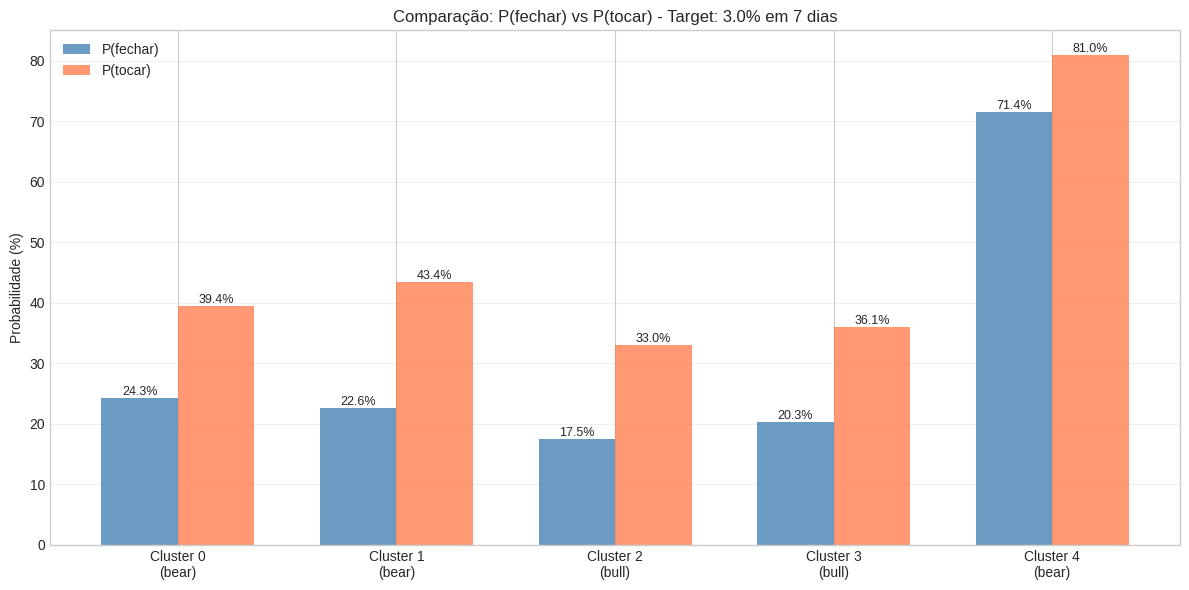


=== Ratio Touch/Close por Cluster ===
Cluster 0 (bear): 1.62x mais provável tocar que fechar
Cluster 1 (bear): 1.92x mais provável tocar que fechar
Cluster 2 (bull): 1.88x mais provável tocar que fechar
Cluster 3 (bull): 1.78x mais provável tocar que fechar
Cluster 4 (bear): 1.13x mais provável tocar que fechar


In [42]:
# Gráfico comparativo: P(fechar) vs P(tocar) por cluster
dual_report = dual_calc.generate_report(df_dual)

fig, ax = plt.subplots(figsize=(12, 6))

clusters_list = sorted(dual_report['conditional_probabilities'].keys())
x = np.arange(len(clusters_list))
width = 0.35

close_probs = [dual_report['conditional_probabilities'][c]['prob_close'] * 100 for c in clusters_list]
touch_probs = [dual_report['conditional_probabilities'][c]['prob_touch'] * 100 for c in clusters_list]

bars1 = ax.bar(x - width/2, close_probs, width, label='P(fechar)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, touch_probs, width, label='P(tocar)', color='coral', alpha=0.8)

# Labels nos clusters
cluster_labels = []
for c in clusters_list:
    interp = best_interp.get(int(float(c)), 'unknown')
    cluster_labels.append(f"Cluster {int(float(c))}\n({interp})")

ax.set_xticks(x)
ax.set_xticklabels(cluster_labels)
ax.set_ylabel('Probabilidade (%)')
ax.set_title(f'Comparação: P(fechar) vs P(tocar) - Target: {ga_config.target_return:.1%} em {ga_config.horizon} dias')
ax.legend()

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Ratio touch/close
print("\n=== Ratio Touch/Close por Cluster ===")
for c in clusters_list:
    data = dual_report['conditional_probabilities'][c]
    ratio = data['touch_vs_close_ratio']
    interp = best_interp.get(int(float(c)), 'unknown')
    print(f"Cluster {int(float(c))} ({interp}): {ratio:.2f}x mais provável tocar que fechar")

In [43]:
# Situação atual com análise dual
last_row = df_dual.iloc[-1]
current_cluster = int(last_row['cluster'])
current_interp = best_interp.get(current_cluster, 'unknown')

current_data = dual_report['conditional_probabilities'][str(float(current_cluster))]
current_prob_close = current_data['prob_close'] * 100
current_prob_touch = current_data['prob_touch'] * 100

print("=" * 60)
print("SITUAÇÃO ATUAL - ANÁLISE DUAL")
print("=" * 60)
print(f"\nData: {last_row['date'].strftime('%Y-%m-%d')}")
print(f"Preço: R$ {last_row['close']:.2f}")
print(f"Regime: Cluster {current_cluster} ({current_interp.upper()})")

# Mostrar indicadores atuais incluindo trend
print(f"\n=== Indicadores Atuais ===")
print(f"  Slope ({best.window_slope}d): {last_row[f'slope_{best.window_slope}']:.6f}")
if best.use_trend_indicator:
    trend_col = f'trend_indicator_norm_{best.window_trend_indicator}'
    trend_value = last_row[trend_col]
    trend_interpretation = "BULLISH" if trend_value > 0.3 else "BEARISH" if trend_value < -0.3 else "NEUTRAL"
    print(f"  Trend Indicator ({best.window_trend_indicator}d, mult={best.trend_slope_multiplier}): {trend_value:.4f} ({trend_interpretation})")

print(f"\nProbabilidade de atingir {ga_config.target_return:.1%} em {ga_config.horizon} dias:")
print(f"  P(fechar ≥ alvo): {current_prob_close:.1f}%")
print(f"  P(tocar o alvo):  {current_prob_touch:.1f}%")
print(f"  Ratio:            {current_prob_touch/current_prob_close:.2f}x")

print(f"\n📈 Interpretação:")
print(f"  É {current_prob_touch/current_prob_close:.1f}x mais provável o preço TOCAR o alvo")
print(f"  do que FECHAR acima dele.")
print(f"\n  Isso é útil para:")
print(f"  - Opções: P(tocar) relevante para barreiras knock-in/knock-out")
print(f"  - Trading: P(tocar) para stop-loss e take-profit")

SITUAÇÃO ATUAL - ANÁLISE DUAL

Data: 2025-12-01
Preço: R$ 155.50
Regime: Cluster 2 (BULL)

=== Indicadores Atuais ===
  Slope (51d): 0.002307

Probabilidade de atingir 3.0% em 7 dias:
  P(fechar ≥ alvo): 17.5%
  P(tocar o alvo):  33.0%
  Ratio:            1.88x

📈 Interpretação:
  É 1.9x mais provável o preço TOCAR o alvo
  do que FECHAR acima dele.

  Isso é útil para:
  - Opções: P(tocar) relevante para barreiras knock-in/knock-out
  - Trading: P(tocar) para stop-loss e take-profit


## Etapa 16: Salvando o Modelo para Produção

Usamos `RegimePredictor` para encapsular o modelo treinado e facilitar previsões futuras.

In [44]:
from src.prediction import RegimePredictor

# Criar predictor a partir dos resultados do GA
predictor = RegimePredictor(
    chromosome=best,                      # Cromossomo otimizado
    target_return=ga_config.target_return,
    horizon=ga_config.horizon,
    ticker=ticker,
    data_dir="../data"
)

# Treinar com os dados históricos
predictor.fit(df)

# Salvar modelo para uso futuro
predictor.save("../models/bova11_predictor")
print("✅ Modelo salvo em ../models/bova11_predictor.joblib e .json")

# Carregar modelo (simulando uso em produção)
predictor_loaded = RegimePredictor.load("../models/bova11_predictor", data_dir="../data")
print("✅ Modelo carregado com sucesso!")

# Fazer previsão do regime atual
result = predictor_loaded.predict_current()

# Exibir status formatado
predictor_loaded.print_status(result)

✅ Modelo salvo em ../models/bova11_predictor.joblib e .json
✅ Modelo carregado com sucesso!
REGIME ATUAL

Ticker: BOVA11.SA
Data: 2025-12-01
Preço: R$ 155.50

📊 Regime: Cluster 2 (BULL)

📈 Probabilidade de atingir 3.0% em 7 dias:
   Condicional (regime atual): 17.5%
   Incondicional (média):      21.3%

   ⚠️  3.8% pontos ABAIXO da média

🔧 Features:
   slope_51: 0.002307
   ma_dist_5_26: 0.689475


## Etapa 17: Grade de Strikes para Opções

O `StrikeGridOptimizer` otimiza parâmetros do GA para uma grade de strikes de opções.
Usando o **Strategy Pattern**, podemos calcular duas métricas diferentes:

- **P(close)**: Probabilidade de **fechar** acima/abaixo do strike no vencimento
- **P(touch)**: Probabilidade de **tocar** o strike em algum momento até o vencimento

**Fluxo:**
1. Define strikes (ex: R$ 148, 150, 152...)
2. Converte cada strike para target return: `(strike / preço_atual) - 1`
3. Roda GA independente para cada target
4. Gera matriz de probabilidades por strike e por estratégia

**NOTA**: Esta etapa é computacionalmente intensiva. Cada estratégia executa GAs separados.

In [45]:
# Etapa 17a: Otimização de Grade de Strikes - P(close)
# Probabilidade de FECHAR acima/abaixo do strike no vencimento

from src.optimization import StrikeGridOptimizer
from src.optimization.progress_callback import SimpleProgressCallback
from src.prediction import StrikeGridPredictor
from src.analysis import CompositeExplainer, DecisionTreeExplainer

# Preço atual do ativo
current_price = df['close'].iloc[-1]
print(f"Preço atual: R$ {current_price:.2f}")

# Definir strikes (exemplo para BOVA11)
strikes = list(range(int(current_price * 0.95), int(current_price * 1.10), 1))  # -5% a +10%, step de R$ 1
print(f"\nStrikes definidos: {strikes}")
print(f"Total de GAs a executar: {len(strikes)}")

# Preview da conversão strike → target
print("\n=== Preview Strike → Target ===")
print(f"{'Strike':<12} {'Retorno':<12} {'Direção':<10}")
print("-" * 34)
for strike in strikes[:5]:
    target_return = (strike / current_price) - 1
    direction = 'UP' if target_return > 0 else 'DOWN' if target_return < 0 else 'ATM'
    print(f"R$ {strike:<9.2f} {target_return*100:+.2f}%       {direction:<10}")
if len(strikes) > 5:
    print(f"... ({len(strikes) - 5} mais)")

# Usando multi_ga_config da célula de configuração centralizada
print(f"\nUsando multi_ga_config da célula centralizada:")
print(f"  População: {multi_ga_config.population_size}")
print(f"  Gerações: {multi_ga_config.generations}")
print(f"  Early Stopping: {multi_ga_config.early_stopping}")

# Factory para criar callback de progresso para cada GA
def create_ga_callback(strike_idx, strike):
    return SimpleProgressCallback(
        total_generations=multi_ga_config.generations,
        print_every=5  # Atualiza a cada 5 gerações
    )

# Executar otimização
strike_optimizer = StrikeGridOptimizer(
    df=df,
    current_price=current_price,
    strikes=strikes,
    horizon=HORIZON,
    ga_config=multi_ga_config
)

print(f"\n⏳ Iniciando otimização para {len(strikes)} strikes...")

strike_results = strike_optimizer.run(
    verbose=True,
    ga_progress_callback_factory=create_ga_callback,
    parallel_ga=False  # Melhor para Jupyter notebooks
)

# Salvar resultados
strike_results.save("../models/strike_grid_h2")

# ============================================================================
# EXPLICAÇÃO DOS CLUSTERS POR STRIKE
# ============================================================================
print("\n" + "=" * 70)
print("EXPLICAÇÃO DOS CLUSTERS POR STRIKE")
print("=" * 70)

# Armazenar explicações
strike_explanations = {}

for strike, result in strike_results.results.items():
    print(f"\n--- Strike R$ {strike:.2f} ---")
    
    # Criar pipeline e processar dados com os parâmetros do strike
    # result é MultiTargetResult, acessar cromossomo via ga_result.best_chromosome
    from src.optimization.calculator_factory import CalculatorFactory
    
    best_chromosome = result.ga_result.best_chromosome
    
    factory = CalculatorFactory(horizon=HORIZON)
    strike_pipeline = factory.create_pipeline(best_chromosome)
    feature_cols_strike = factory.get_feature_columns(best_chromosome)
    
    # Processar dados
    df_strike = strike_pipeline.run(df)
    
    # Clustering
    strike_kmeans = KMeansRegimeClassifier(
        n_clusters=best_chromosome.n_clusters,
        feature_columns=feature_cols_strike
    )
    df_strike = strike_kmeans.fit_predict(df_strike)
    
    # Explicar clusters
    strike_explainer = DecisionTreeExplainer(max_depth=4, min_samples_leaf=20)
    strike_explainer.fit(df_strike, cluster_column='cluster', feature_columns=feature_cols_strike)
    
    # Métricas
    metrics = strike_explainer.get_metrics()
    print(f"  Accuracy: {metrics.cv_accuracy_mean:.1%} (+/- {metrics.cv_accuracy_std:.1%})")
    
    # Top features
    print(f"  Top Features:")
    for feature, importance in strike_explainer.get_top_features(3):
        print(f"    - {feature}: {importance:.3f}")
    
    # Guardar explicação
    strike_explanations[strike] = {
        'explainer': strike_explainer,
        'top_features': strike_explainer.get_top_features(3),
        'accuracy': metrics.cv_accuracy_mean,
        'rules': strike_explainer.get_rules()
    }

# Criar predictor
strike_predictor = StrikeGridPredictor.from_optimization(strike_results, df)
strike_predictor.save("../models/strike_grid_h2_predictor")

# Ver matriz de strikes
strike_predictor.print_matrix(ticker)

Preço atual: R$ 155.50

Strikes definidos: [147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
Total de GAs a executar: 24

=== Preview Strike → Target ===
Strike       Retorno      Direção   
----------------------------------
R$ 147.00    -5.47%       DOWN      
R$ 148.00    -4.82%       DOWN      
R$ 149.00    -4.18%       DOWN      
R$ 150.00    -3.54%       DOWN      
R$ 151.00    -2.89%       DOWN      
... (19 mais)

Usando multi_ga_config da célula centralizada:
  População: 50
  Gerações: 100
  Early Stopping: True

⏳ Iniciando otimização para 24 strikes...
STRIKE GRID OPTIMIZATION (CLOSE)
Estratégia: P(close)
Preço atual: R$ 155.50
Horizonte: 7 dias
Strikes: 24 (147.00 a 170.00)
GA gerações: 100
População: 50

Mapeamento Strike → Target:
Strike       Retorno      Direção   
----------------------------------
R$ 147.00    -5.47%       DOWN      
R$ 148.00    -4.82%       DOWN      
R$ 149.00    -4.18%       D

RESUMO: FEATURES MAIS IMPORTANTES POR STRIKE
Strike Target   Top Feature Importance Accuracy
R$ 147  -5.5% ma_dist_12_21      0.645    93.0%
R$ 148  -4.8% ma_dist_15_21      0.627    93.1%
R$ 149  -4.2%  ma_dist_8_25      0.642    93.8%
R$ 150  -3.5% ma_dist_10_27      0.626    92.9%
R$ 151  -2.9%  ma_dist_7_42      0.612    92.0%
R$ 152  -2.3%  ma_dist_8_25      0.632    92.2%
R$ 153  -1.6%      slope_39      0.581    90.9%
R$ 154  -1.0%  ma_dist_8_27      0.622    92.8%
R$ 155  -0.3%  ma_dist_8_29      0.627    93.4%
R$ 156  +0.3%  ma_dist_9_26      0.632    92.9%
R$ 157  +1.0%       slope_8      0.563    89.4%
R$ 158  +1.6% ma_dist_12_20      0.653    94.1%
R$ 159  +2.3% ma_dist_11_22      0.627    92.0%
R$ 160  +2.9%      slope_41      0.525    90.3%
R$ 161  +3.5%      slope_11      0.569    90.1%
R$ 162  +4.2%  ma_dist_8_21      0.515    95.5%
R$ 163  +4.8%  ma_dist_5_33      0.640    91.6%
R$ 164  +5.5% ma_dist_19_25      0.638    91.6%
R$ 165  +6.1%  ma_dist_8_21      0.602    9

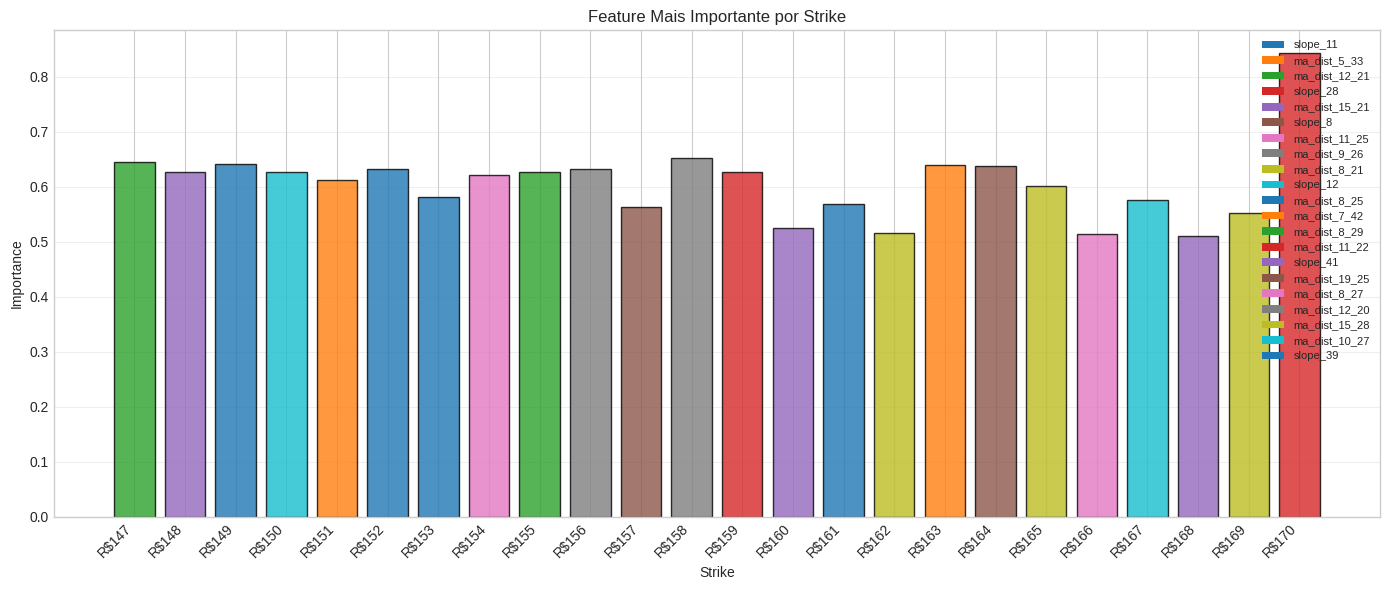

In [46]:
# Resumo das explicações por strike - Visualização
print("=" * 70)
print("RESUMO: FEATURES MAIS IMPORTANTES POR STRIKE")
print("=" * 70)

# Criar DataFrame com resumo
summary_data = []
for strike, explanation in strike_explanations.items():
    top_feat = explanation['top_features'][0] if explanation['top_features'] else ('N/A', 0)
    summary_data.append({
        'Strike': f"R$ {strike:.0f}",
        'Target': f"{((strike / current_price) - 1) * 100:+.1f}%",
        'Top Feature': top_feat[0],
        'Importance': f"{top_feat[1]:.3f}",
        'Accuracy': f"{explanation['accuracy']:.1%}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Gráfico: Feature mais importante por strike
fig, ax = plt.subplots(figsize=(14, 6))

strike_values = list(strike_explanations.keys())
top_features_by_strike = [exp['top_features'][0][0] if exp['top_features'] else 'N/A' 
                          for exp in strike_explanations.values()]
importances = [exp['top_features'][0][1] if exp['top_features'] else 0 
               for exp in strike_explanations.values()]

# Cores por feature
unique_features = list(set(top_features_by_strike))
color_palette = plt.cm.tab10.colors
feature_colors = {feat: color_palette[i % len(color_palette)] for i, feat in enumerate(unique_features)}
bar_colors = [feature_colors[feat] for feat in top_features_by_strike]

bars = ax.bar(range(len(strike_values)), importances, color=bar_colors, edgecolor='black', alpha=0.8)

ax.set_xticks(range(len(strike_values)))
ax.set_xticklabels([f"R${s:.0f}" for s in strike_values], rotation=45, ha='right')
ax.set_xlabel('Strike')
ax.set_ylabel('Importance')
ax.set_title('Feature Mais Importante por Strike')

# Legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=feat) for feat, color in feature_colors.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Etapa 17b: Otimização de Grade de Strikes - P(touch)

Agora usamos a **TouchReturnStrategy** para calcular P(touch) - a probabilidade de **tocar** o strike
em algum momento durante o período, não apenas no fechamento.

- Para targets **positivos** (calls): usa `log_return_touch_max`
- Para targets **negativos** (puts): usa `log_return_touch_min`

In [47]:
# Etapa 17b: Otimização de Grade de Strikes - P(touch)
# Probabilidade de TOCAR o strike em algum momento até o vencimento

from src.optimization import StrikeGridOptimizer, TouchReturnStrategy
from src.optimization.progress_callback import SimpleProgressCallback
from src.prediction import StrikeGridPredictor

# Usar os mesmos strikes definidos anteriormente
print(f"Preço atual: R$ {current_price:.2f}")
print(f"Strikes: {strikes}")
print(f"\nEstratégia: P(touch) - TouchReturnStrategy")

# Factory para criar callback de progresso para cada GA
def create_ga_callback_touch(strike_idx, strike):
    return SimpleProgressCallback(
        total_generations=multi_ga_config.generations,
        print_every=5
    )

# Criar estratégia de toque
touch_strategy = TouchReturnStrategy()

# Executar otimização com TouchReturnStrategy
strike_optimizer_touch = StrikeGridOptimizer(
    df=df,
    current_price=current_price,
    strikes=strikes,
    horizon=HORIZON,
    ga_config=multi_ga_config,
    strategy=touch_strategy  # ← Estratégia de TOQUE
)

print(f"\n⏳ Iniciando otimização P(touch) para {len(strikes)} strikes...")

strike_results_touch = strike_optimizer_touch.run(
    verbose=True,
    ga_progress_callback_factory=create_ga_callback_touch,
    parallel_ga=False
)

# Salvar resultados com sufixo _touch
strike_results_touch.save("../models/strike_grid_h2_touch")

# Criar predictor para touch
strike_predictor_touch = StrikeGridPredictor.from_optimization(strike_results_touch, df)
strike_predictor_touch.save("../models/strike_grid_h2_touch_predictor")

# Ver matriz de strikes para P(touch)
print("\n" + "=" * 70)
print("MATRIZ DE P(TOUCH)")
print("=" * 70)
strike_predictor_touch.print_matrix(ticker)

Preço atual: R$ 155.50
Strikes: [147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]

Estratégia: P(touch) - TouchReturnStrategy

⏳ Iniciando otimização P(touch) para 24 strikes...
STRIKE GRID OPTIMIZATION (TOUCH)
Estratégia: P(touch)
Preço atual: R$ 155.50
Horizonte: 7 dias
Strikes: 24 (147.00 a 170.00)
GA gerações: 100
População: 50

Mapeamento Strike → Target:
Strike       Retorno      Direção   
----------------------------------
R$ 147.00    -5.47%       DOWN      
R$ 148.00    -4.82%       DOWN      
R$ 149.00    -4.18%       DOWN      
R$ 150.00    -3.54%       DOWN      
R$ 151.00    -2.89%       DOWN      
... (19 mais)


[1/24] Strike R$ 147.00 (target -5.47%)
[======>.......................]  21.0% | Gen 21/100 | Fitness: 0.3744 | Delta P: 0.3822 | ETA: 41s        
✅ Strike R$ 147.00 concluído:
    Fitness: 0.3744
    Delta P (test): 0.3822
    Parâmetros: slope=41, clusters=5

[2/24] Strike R$ 148.00 (targe

### Etapa 17c: Comparação P(fechar) vs P(tocar)

Tabela consolidada comparando as duas métricas de probabilidade para cada strike.

In [48]:
# Etapa 17c: Comparação P(fechar) vs P(tocar)
# Tabela consolidada com probabilidades condicionais e incondicionais

import pandas as pd

# Carregar predictors salvos
from src.prediction import StrikeGridPredictor

predictor_close = StrikeGridPredictor.load("../models/strike_grid_h2_predictor")
predictor_touch = StrikeGridPredictor.load("../models/strike_grid_h2_touch_predictor")

print(f"Predictor Close - Strategy: {predictor_close.strategy_name}")
print(f"Predictor Touch - Strategy: {predictor_touch.strategy_name}")

# Obter predições atuais para ambas as estratégias
df_close = predictor_close.predict_current(ticker)
df_touch = predictor_touch.predict_current(ticker)

# Construir tabela comparativa
comparison_rows = []

for _, row_close in df_close.iterrows():
    strike = row_close['strike']
    target_pct = row_close['target_return'] * 100
    direction = "CALL" if target_pct > 0.5 else "PUT" if target_pct < -0.5 else "ATM"
    
    # P(fechar) - condicional e incondicional
    p_fech_cond = row_close['probability'] * 100
    p_fech_base = row_close['probability_unconditional'] * 100
    regime_close = row_close['interpretation']
    
    # P(tocar) - encontrar linha correspondente
    row_touch = df_touch[df_touch['strike'] == strike]
    if len(row_touch) > 0:
        row_touch = row_touch.iloc[0]
        p_toc_cond = row_touch['probability'] * 100
        p_toc_base = row_touch['probability_unconditional'] * 100
        regime_touch = row_touch['interpretation']
    else:
        p_toc_cond = p_toc_base = None
        regime_touch = "N/A"
    
    comparison_rows.append({
        'Strike': strike,
        'Target': f"{target_pct:+.1f}%",
        'Tipo': direction,
        # Condicionais (dado o regime atual)
        'P(fech)|R': p_fech_cond,
        'P(toc)|R': p_toc_cond,
        # Incondicionais (base)
        'P(fech)': p_fech_base,
        'P(toc)': p_toc_base,
        # Regimes
        'Reg_F': regime_close[:4] if regime_close else "",
        'Reg_T': regime_touch[:4] if regime_touch else ""
    })

# Criar DataFrame
df_comp = pd.DataFrame(comparison_rows)

# ATM strike
atm_strike = min(df_comp['Strike'], key=lambda x: abs(x - current_price))

# Formatar para exibição
print()
print("=" * 115)
print(f"COMPARAÇÃO: P(fechar) vs P(tocar) - {ticker}")
print(f"Preço atual: R$ {current_price:.2f} | Horizonte: {HORIZON} dias")
print("=" * 115)
print()

# Header
print(f"{'Strike':>8} {'Target':>7} {'Tipo':>4} │ {'P(fech)|R':>9} {'P(fech)':>8} │ {'P(toc)|R':>9} {'P(toc)':>8} │ {'Δ(cond)':>8} {'Δ(base)':>8} │ {'Reg':>9}")
print("-" * 115)

for _, row in df_comp.iterrows():
    strike = row['Strike']
    
    # Probabilidades condicionais
    pf_cond = f"{row['P(fech)|R']:.1f}%" if row['P(fech)|R'] is not None else "N/A"
    pt_cond = f"{row['P(toc)|R']:.1f}%" if row['P(toc)|R'] is not None else "N/A"
    
    # Probabilidades base (incondicionais)
    pf_base = f"{row['P(fech)']:.1f}%" if row['P(fech)'] is not None else "N/A"
    pt_base = f"{row['P(toc)']:.1f}%" if row['P(toc)'] is not None else "N/A"
    
    # Diferenças P(toc) - P(fech)
    if row['P(toc)|R'] is not None and row['P(fech)|R'] is not None:
        diff_cond = row['P(toc)|R'] - row['P(fech)|R']
        diff_cond_str = f"{diff_cond:+.1f}%"
    else:
        diff_cond_str = "N/A"
        
    if row['P(toc)'] is not None and row['P(fech)'] is not None:
        diff_base = row['P(toc)'] - row['P(fech)']
        diff_base_str = f"{diff_base:+.1f}%"
    else:
        diff_base_str = "N/A"
    
    regime = f"{row['Reg_F']}/{row['Reg_T']}"
    atm_marker = " ← ATM" if strike == atm_strike else ""
    
    print(f"R$ {strike:>5.0f} {row['Target']:>7} {row['Tipo']:>4} │ {pf_cond:>9} {pf_base:>8} │ {pt_cond:>9} {pt_base:>8} │ {diff_cond_str:>8} {diff_base_str:>8} │ {regime:>9}{atm_marker}")

print("-" * 115)
print()
print("Legenda:")
print("  P(fech)|R  = P(fechar | regime) - Probabilidade CONDICIONAL de fechar acima/abaixo do strike")
print("  P(fech)    = P(fechar) - Probabilidade INCONDICIONAL (base histórica)")
print("  P(toc)|R   = P(tocar | regime) - Probabilidade CONDICIONAL de tocar o strike")
print("  P(toc)     = P(tocar) - Probabilidade INCONDICIONAL (base histórica)")
print("  Δ(cond)    = P(toc)|R - P(fech)|R → diferença das condicionais")
print("  Δ(base)    = P(toc) - P(fech) → diferença das incondicionais (deve ser sempre POSITIVO)")
print("  Reg        = Regime atual (fechar/tocar)")
print()

# Validação e Insights
valid_rows = [r for r in comparison_rows if r['P(toc)'] is not None]
if valid_rows:
    # Diferenças médias
    avg_diff_cond = sum(r['P(toc)|R'] - r['P(fech)|R'] for r in valid_rows) / len(valid_rows)
    avg_diff_base = sum(r['P(toc)'] - r['P(fech)'] for r in valid_rows) / len(valid_rows)
    
    # Validação: P(toc) base deve ser >= P(fech) base
    all_positive_base = all(r['P(toc)'] >= r['P(fech)'] for r in valid_rows)
    
    print("📊 INSIGHTS:")
    print(f"  • Δ médio (condicional): P(toc)|R - P(fech)|R = {avg_diff_cond:+.1f}%")
    print(f"  • Δ médio (incondicional): P(toc) - P(fech) = {avg_diff_base:+.1f}%")
    print()
    
    if all_positive_base:
        print("  ✅ VALIDAÇÃO OK: P(tocar) >= P(fechar) para todas as probabilidades base")
    else:
        negative = [r for r in valid_rows if r['P(toc)'] < r['P(fech)']]
        print(f"  ⚠️ ALERTA: {len(negative)} strikes com P(tocar) < P(fechar) nas bases - verificar cálculos!")
        for r in negative[:3]:
            print(f"      Strike R$ {r['Strike']:.0f}: P(toc)={r['P(toc)']:.1f}% < P(fech)={r['P(fech)']:.1f}%")


Predictor Close - Strategy: close
Predictor Touch - Strategy: touch

COMPARAÇÃO: P(fechar) vs P(tocar) - BOVA11.SA
Preço atual: R$ 155.50 | Horizonte: 7 dias

  Strike  Target Tipo │ P(fech)|R  P(fech) │  P(toc)|R   P(toc) │  Δ(cond)  Δ(base) │       Reg
-------------------------------------------------------------------------------------------------------------------
R$   147   -5.5%  PUT │      1.8%     4.6% │      6.0%    11.0% │    +4.3%    +6.4% │ bull/bull
R$   148   -4.8%  PUT │      3.2%     6.4% │      9.9%    15.2% │    +6.7%    +8.8% │ bull/bull
R$   149   -4.2%  PUT │      4.9%     8.6% │     16.9%    21.0% │   +12.0%   +12.3% │ bull/bull
R$   150   -3.5%  PUT │      7.8%    12.5% │     24.8%    28.1% │   +17.0%   +15.5% │ bull/bull
R$   151   -2.9%  PUT │     12.4%    17.1% │     31.9%    36.2% │   +19.5%   +19.1% │ bull/bull
R$   152   -2.3%  PUT │     19.0%    22.5% │     44.2%    46.4% │   +25.2%   +23.9% │ bull/flat
R$   153   -1.6%  PUT │     23.3%    28.8% │     58.6

## Conclusão

Este notebook demonstrou o fluxo completo do sistema QuantNote:

1. **Configuração** com validação via Pydantic
2. **Obtenção de dados** do Yahoo Finance com rate limiting
3. **Validação** de dados com múltiplos validators
4. **Pipeline de calculadores** com resolução automática de dependências
5. **Classificação de regimes** (manual e K-Means)
6. **Cálculo de probabilidades** condicionais
7. **Visualização** de distribuições
8. **Walk-forward validation** para evitar overfitting
9. **Otimização** com algoritmo genético
10. **Análise dual** - P(fechar) vs P(tocar)

### Métricas de Probabilidade

- **P(fechar)**: Probabilidade de fechar acima do alvo no final do período
- **P(tocar)**: Probabilidade de atingir o alvo em algum momento durante o período

### Próximos Passos

- Testar com outros ativos
- Ajustar parâmetros do GA para busca mais ampla
- Implementar novos indicadores (RSI, MACD, etc.)
- Integrar com sistema de backtesting
- Usar P(tocar) para otimização de opções